# Image based diagnosis of pneumonia.
This mini-project concerns diagnozing pneumonia from chest XRay images. To learn more, see:
https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia/home

Data: https://data.mendeley.com/datasets/rscbjbr9sj/2

Context: https://www.cell.com/cell/fulltext/S0092-8674(18)30154-5

This notebook was computed using Google Cloud Datalab instance, so some code specific only to that envronment.

In [17]:
# Necessary imports
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import pickle
from skimage.data import imread
from skimage.transform import resize
from tensorflow.python.lib.io import file_io
import sys
print("Finished importing")

# Jupyter magic commands
% matplotlib inline

Finished importing


List the the devices and check if GPU is available

In [3]:
from tensorflow.python.client import device_lib
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']
print(get_available_gpus())

print(device_lib.list_local_devices())

['/device:GPU:0']
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14074434509869132252
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11286285517
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5604027485343846905
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


### Load and explore the data

Grab the dataset from the Google Cloud Storage. The dataset is divided into three subsets: train set, validation set and test set. Each of the subsets contains two subdirectories: NORMAL (normal cases, without pneumonia) and PNEUMONIA (pneumonia cases). First we will grab appropriate bucket.

In [15]:
import google.datalab.storage as storage
from google.datalab import Context   # Utilities for handling Google Storage API
import random, string   

project = Context.default().project_id   # Get project ID

# Get the bucket and it's path
bucket_name = project + '-input'
bucket_path = 'gs://' + bucket_name
print(bucket_path)

# Get actual data directory
data_dir = bucket_path + "/chest-xray-pneumonia/chest_xray/chest_xray/"
print(data_dir)

# Get train and test data directories, each belonging to specific class
train_normal_dir = "chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/"
train_pneumonia_dir = "chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/"

test_normal_dir = "chest-xray-pneumonia/chest_xray/chest_xray/test/NORMAL/"
test_pneumonia_dir = "chest-xray-pneumonia/chest_xray/chest_xray/test/PNEUMONIA/"

# Create two lists, with train and test data
# Each of the elements of the list is the image directory with corresponding label
train_data = []
test_data = []

for obj in storage.Bucket(bucket_name).objects():
    if obj.key.startswith(train_normal_dir) and str(obj.key)[-4:] == "jpeg":
        img_dir = bucket_path + "/" + str(obj.key)
        label = 0
        train_data.append((img_dir, label))
    if obj.key.startswith(train_pneumonia_dir) and str(obj.key)[-4:] == "jpeg":
        img_dir = bucket_path + "/" + str(obj.key)
        label = 1
        train_data.append((img_dir, label))
    if obj.key.startswith(test_normal_dir) and str(obj.key)[-4:] == "jpeg":
        img_dir = bucket_path + "/" + str(obj.key)
        label = 0
        test_data.append((img_dir, label))
    if obj.key.startswith(test_pneumonia_dir) and str(obj.key)[-4:] == "jpeg":
        img_dir = bucket_path + "/" + str(obj.key)
        label = 1
        test_data.append((img_dir, label))
print(train_data[0])
print(test_data[0])
print(len(train_data), len(test_data))

# Put both lists into Pandas Dataframe and shuffle them
train_data = pd.DataFrame(train_data, columns=["image_filepath", "label"])
train_data = train_data.sample(frac=1.).reset_index(drop=True)

test_data = pd.DataFrame(test_data, columns=["image_filepath", "label"])
test_data = test_data.sample(frac=1.).reset_index(drop=True)

print(train_data.shape, test_data.shape)

gs://apt-index-209417-input
gs://apt-index-209417-input/chest-xray-pneumonia/chest_xray/chest_xray/
('gs://apt-index-209417-input/chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/IM-0115-0001.jpeg', 0)
('gs://apt-index-209417-input/chest-xray-pneumonia/chest_xray/chest_xray/test/NORMAL/IM-0001-0001.jpeg', 0)
5215 624
(5215, 2) (624, 2)


Define a generator for yielding train image data during training

In [5]:
def data_generator(data, batch_size=64, input_shape=(224, 224)):
    # Get total number of samples
    n = data.shape[0]
    steps = n // batch_size
    
    # Define two empty arrays for storing batch data
    batch_images = np.zeros((batch_size, 224, 224, 3), dtype=np.float32)
    batch_labels = np.zeros((batch_size, 2), dtype=np.float32)
    
    # Get a numpy array of all the indices of the input data
    indices = np.arange(n)
    i = 0
    while True:
        count = 0
        # Get the next batch
        batch_indices = indices[(i *batch_size):min((i + 1) * batch_size, n)]
        for j, idx in enumerate(batch_indices):
            img_path = data.iloc[idx]["image_filepath"]
            label = data.iloc[idx]["label"]
            # One hot encoding of the label
            if label == 1:
                encoded_label = np.array([0., 1.])
            elif label == 0:
                encoded_label = np.array([1., 0.])
#             print(j, idx, label, encoded_label)   for debugging
#             time.sleep(2)
            # Read and resize the image
            with file_io.FileIO(img_path, mode ='rb') as f:   # Loading this way is  
                img = imread(f)                               # specific to Google Storage
            img = resize(img, input_shape)
            # Some of the images are in grayscale (one channel), some don't. If they are,  
            # stack them so that all have three channels
            if len(img.shape) == 2:
                img = np.dstack([img, img, img])
            # Normalize the image pixels
            img = img.astype(np.float32)/255.
            # Add image and corresponding label to batch_data
            batch_images[j] = img
            batch_labels[j] = encoded_label
#             if j % 100 == 0:
#               print(j, "images done")
        yield batch_images, batch_labels
        i += 1
        if i >= steps:
            i = 0

I wanted to use above generator to yield batches in progress during training. However, it turned out that in the datalab environment the code was very unstable and after some traning steps was becoming very slow. On the local machine that was not the case, so this may be due to the characteristic of getting data from Google Storage. Instead, I generated whole training and test set using this generator to generate "batch" with whole data as numpy arrays.

Load training and testing data from .npy files

In [2]:
test_labels = np.load("test_labels.npy")
print(test_labels.shape)

(624, 2)


In [3]:
test_images = np.load("test_images.npy")
print(test_images.shape)

(624, 224, 224, 3)


In [4]:
train_labels = np.load("train_labels.npy")
print(train_labels.shape)

(5215, 2)


In [5]:
train_images = np.load("train_images.npy")
print(train_images.shape)

(5215, 224, 224, 3)


Check the classes distribution in the training data

In [6]:
print("Total number of samples in the training data: {}".format(train_images.shape[0]))
print("Number of pneumonia cases: {}".format(np.argmax(train_labels, 1).sum()))
print("Number of normal cases: {}".format(train_labels.shape[0] - np.argmax(train_labels, 1).sum()))

Total number of samples in the training data: 5215
Number of pneumonia cases: 3875
Number of normal cases: 1340


As one can see, the data is highly inbalanced. This might be significant issue, because negative cases could be hard for the model to detect.

Display sample images coming from pneumonia nad normal cases

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


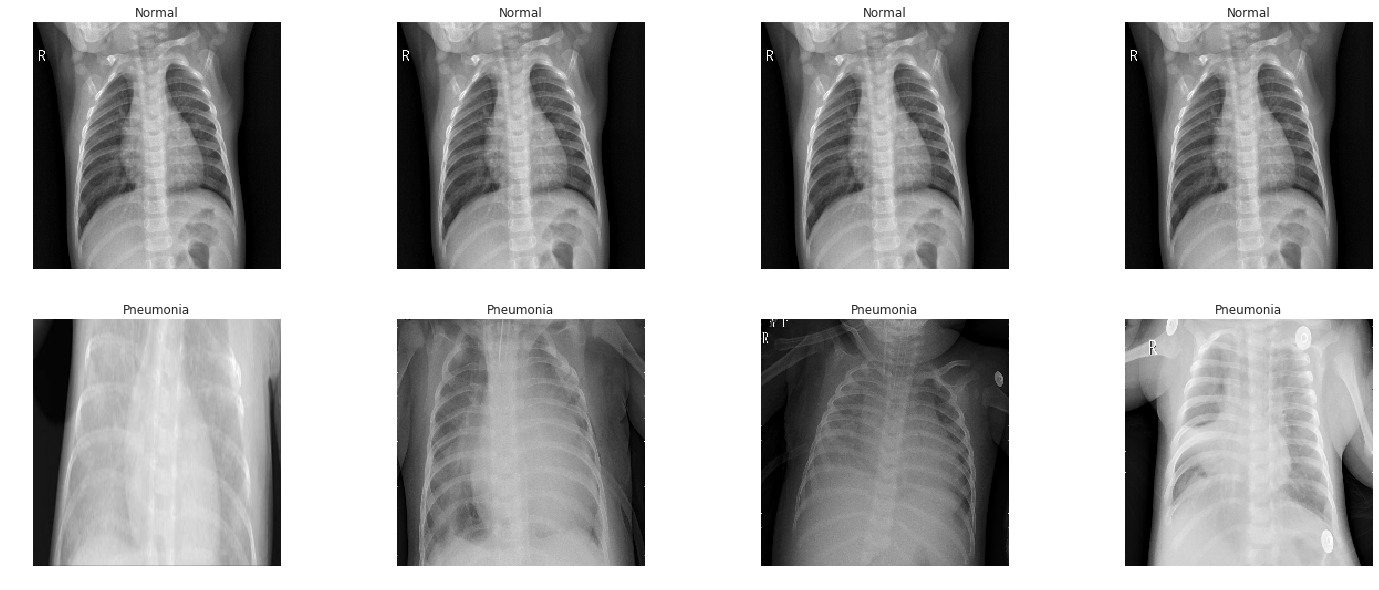

In [7]:
normal_indices = []
pneumonia_indices = []

normal_c = 0
pneumonia_c = 0
i = 0
plt.figure(figsize=(25, 10))
while(True):
    label = train_labels[i]
    if label[0] == 1:   # Normal case
        normal_indices.append(i)
        normal_c += 1
        if normal_c == 4:
          break
    i += 1
    i = 0
while(True):
    label = train_labels[i]
    if label[0] == 0:   # Pneumonia case
        pneumonia_indices.append(i)
        pneumonia_c += 1
        if pneumonia_c == 4:
          break
    i += 1

fig = plt.figure(figsize=(25, 10))
c = 0
for i in normal_indices:
    plt.subplot(2, 4, c + 1)
    plt.title("Normal")
    plt.axis("off")
    
    plt.imshow(train_images[i, :, :, 0], cmap="gray")
    c += 1
    
c = 0
for i in pneumonia_indices:
    plt.subplot(2, 4, c + 5)
    plt.title("Pneumonia")
    plt.axis("off")
    
    plt.imshow(train_images[i, :, :, 0], cmap="gray")
    c += 1
    
plt.show()

### Modelling with self-trained convolutional neural network
The most common way of approaching task like medical image diagnosis is to use transfer learning, i.e. take one of the deep networks trained on dataset like ImageNet and tune them to specific classification task (for a good example of this using this dataset check https://www.kaggle.com/aakashnain/beating-everything-with-depthwise-convolution). However, I wanted to check if it is possible with custom model learned from scratch only on available data.

Define wrappers for creating often used layers

In [8]:
def conv2d(x, W, b, strides=1, activation=tf.nn.relu):
    # Helper function for creating convolutional layer
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return activation(x)

def maxpool2d(x, k=2):
    # Helper function for creating pooling layer
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1],padding='SAME')

Define weights (TensorFlow variables) for first two models

In [7]:
weights = {
    'wc1': tf.get_variable('W0', shape=(3,3,3,32), initializer=tf.contrib.layers.xavier_initializer()), 
    'wc2': tf.get_variable('W1', shape=(3,3,32,64), initializer=tf.contrib.layers.xavier_initializer()), 
    'wc3': tf.get_variable('W2', shape=(3,3,64,128), initializer=tf.contrib.layers.xavier_initializer()), 
    'wd1': tf.get_variable('W3', shape=(100352,1024), initializer=tf.contrib.layers.xavier_initializer()),
    'wd2': tf.get_variable("W4", shape=(1024,512), initializer=tf.contrib.layers.xavier_initializer()),
    'out': tf.get_variable('W6', shape=(512,2), initializer=tf.contrib.layers.xavier_initializer()), 
}
biases = {
    'bc1': tf.get_variable('B0', shape=(32), initializer=tf.contrib.layers.xavier_initializer()),
    'bc2': tf.get_variable('B1', shape=(64), initializer=tf.contrib.layers.xavier_initializer()),
    'bc3': tf.get_variable('B2', shape=(128), initializer=tf.contrib.layers.xavier_initializer()),
    'bd1': tf.get_variable('B3', shape=(1024), initializer=tf.contrib.layers.xavier_initializer()),
    'bd2': tf.get_variable("B4", shape=(512), initializer=tf.contrib.layers.xavier_initializer()),
    'out': tf.get_variable('B5', shape=(2), initializer=tf.contrib.layers.xavier_initializer()),
}


Define first model architecture

In [7]:
def conv_net0(x, weights, biases):
    """Convolutional neural network with three convolutional layers and two fully connected layers
    with ReLu activation. Pooling is applied after each convolutional layer.
    """
    # Apply the first convolutional layer to the input
    conv1 = conv2d(x, weights["wc1"], biases["bc1"])
    # Down sampling with max pooling
    conv1 = maxpool2d(conv1, k=2)
    
    # Apply the second convolutional layer to the ouptut of the first one
    conv2 = conv2d(conv1, weights["wc2"], biases["bc2"])
    # Down sampling with max pooling
    conv2 = maxpool2d(conv2, k=2)
    
    # Last convolutional layer
    conv3 = conv2d(conv2, weights["wc3"], biases["bc3"])
    conv3 = maxpool2d(conv3, k=2)
    
    # First fully connected layer
    # Flatten the last convolutional layer
    flat1 = tf.contrib.layers.flatten(conv3)
    fc1 = tf.add(tf.matmul(flat1, weights["wd1"]), biases["bd1"])
    fc1 = tf.nn.relu(fc1)
    
    # Second fully connected layer
    fc2 = tf.add(tf.matmul(fc1, weights["wd2"]), biases["bd2"])
    fc2 = tf.nn.relu(fc2)
    
    # Output, class prediction 
    # output = tf.nn.softmax(tf.add(tf.matmul(fc2, weights['out']), biases['out']))
    output = tf.add(tf.matmul(fc2, weights['out']), biases['out'])
    return output

Perform the test run to check out the time performance

In [13]:
learning_rate = 0.001
n_epochs = 2
batch_size = 32
n = train_images.shape[0]
steps = n // batch_size


with tf.device('/device:GPU:0'):    # Make sure to work on the GPU
  x = tf.placeholder("float", [None, 224, 224, 3])
  y = tf.placeholder("float", [None, 2])

  pred = conv_net0(x, weights, biases)
  cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
  optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

  # Check whether the index of the maximum value of the predicted image 
  # is equal to the actual label
  correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))

  # Calculate accuracy across all the given images 
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Initialize the variables
init = tf.global_variables_initializer()

# Run the session
sess = tf.Session()
sess.run(init)
train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
# Iterate over epochs
for epoch in range(n_epochs):
    tep0 = time.time()
    gen = data_generator(train_data, batch_size=batch_size)
    # Iterate over batches
    for batch in range(steps):
        tb0 = time.time()
        batch_x = train_images[batch * batch_size:min((batch + 1) * batch_size, n)]    # Avoid running out of bounds
        batch_y = train_labels[batch * batch_size:min((batch + 1) * batch_size, n)]
        # Run optimization operation (backpropagation) and
        # Compute cost function and batch accuracy
        _, loss, acc = sess.run([optimizer, cost, accuracy], feed_dict={x: batch_x,
                                                                        y: batch_y})
        tb1 = time.time()
        print("Epoch {0}, Batch {1}, time: {2}, loss: {3}, accuracy: {4}".format(
          epoch, batch, tb1 - tb0, loss, acc))
        
    tep1 = time.time()
    print("*******************************")
    print("Epoch {0}, time: {1} seconds, loss: {2}, batch accuracy: {3}".format(
    epoch, tep1 - tep0, loss, acc))
    print("*******************************")

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

Epoch 0, Batch 0, time: 27.58403205871582, loss: 1.0958513021469116, accuracy: 0.21875
Epoch 0, Batch 1, time: 3.88224458694458, loss: 17.212017059326172, accuracy: 0.65625
Epoch 0, Batch 2, time: 0.8280444145202637, loss: 4.654636383056641, accuracy: 0.71875
Epoch 0, Batch 3, time: 0.5409395694732666, loss: 9.754432678222656, accuracy: 0.09375
Epoch 0, Batch 4, time: 0.6919150352478027, loss: 1.040651559829712, accuracy: 0.34375
Epoch 0, Batch 5, time: 0.7150635719299316, loss: 1.6278626918792725, accuracy: 0.75
Epoch 0, Batch 6, time: 0.4836263656616211, loss: 2.2638721466064453, accuracy: 0.6875
Epoch 0, Batch 7, time: 1.6215214729309082, loss: 1.3171014785766602, accuracy: 0.75
Epoch 0, Batch 8, time: 0.6076273918151855, loss: 0.5960534811019897, accuracy: 0.78125
Epoch 0, Batch 9, time: 0.642

Epoch 0, Batch 90, time: 1.3821628093719482, loss: 0.5275394320487976, accuracy: 0.78125
Epoch 0, Batch 91, time: 0.46075940132141113, loss: 0.5663281679153442, accuracy: 0.75
Epoch 0, Batch 92, time: 0.4183921813964844, loss: 0.526669979095459, accuracy: 0.78125
Epoch 0, Batch 93, time: 2.004892349243164, loss: 0.595156192779541, accuracy: 0.71875
Epoch 0, Batch 94, time: 0.5320687294006348, loss: 0.44967204332351685, accuracy: 0.875
Epoch 0, Batch 95, time: 0.4482271671295166, loss: 0.5327592492103577, accuracy: 0.78125
Epoch 0, Batch 96, time: 0.4057199954986572, loss: 0.562321126461029, accuracy: 0.75
Epoch 0, Batch 97, time: 0.6107618808746338, loss: 0.6387630701065063, accuracy: 0.6875
Epoch 0, Batch 98, time: 0.502169132232666, loss: 0.6383810639381409, accuracy: 0.6875
Epoch 0, Batch 99, time: 0.456561803817749, loss: 0.528045654296875, accuracy: 0.78125
Epoch 0, Batch 100, time: 1.3756980895996094, loss: 0.43208277225494385, accuracy: 0.875
Epoch 0, Batch 101, time: 0.83206439

Epoch 1, Batch 19, time: 0.4522418975830078, loss: 0.5283493995666504, accuracy: 0.78125
Epoch 1, Batch 20, time: 0.41504645347595215, loss: 0.6767920851707458, accuracy: 0.65625
Epoch 1, Batch 21, time: 0.5385847091674805, loss: 0.6013367176055908, accuracy: 0.71875
Epoch 1, Batch 22, time: 0.6877346038818359, loss: 0.5990407466888428, accuracy: 0.71875
Epoch 1, Batch 23, time: 0.3476569652557373, loss: 0.5624064207077026, accuracy: 0.75
Epoch 1, Batch 24, time: 0.37409186363220215, loss: 0.6893606185913086, accuracy: 0.625
Epoch 1, Batch 25, time: 0.4290649890899658, loss: 0.7566707134246826, accuracy: 0.53125
Epoch 1, Batch 26, time: 0.3530433177947998, loss: 0.585090160369873, accuracy: 0.75
Epoch 1, Batch 27, time: 0.6527535915374756, loss: 0.6312054395675659, accuracy: 0.6875
Epoch 1, Batch 28, time: 0.3427739143371582, loss: 0.5859761238098145, accuracy: 0.8125
Epoch 1, Batch 29, time: 0.7187395095825195, loss: 0.5922605991363525, accuracy: 0.78125
Epoch 1, Batch 30, time: 0.429

Epoch 1, Batch 112, time: 0.6701765060424805, loss: 0.4957941770553589, accuracy: 0.8125
Epoch 1, Batch 113, time: 0.44030046463012695, loss: 0.6856544613838196, accuracy: 0.65625
Epoch 1, Batch 114, time: 0.34885168075561523, loss: 0.8249098062515259, accuracy: 0.5625
Epoch 1, Batch 115, time: 0.5194647312164307, loss: 0.4876686632633209, accuracy: 0.8125
Epoch 1, Batch 116, time: 0.5240898132324219, loss: 0.5274263620376587, accuracy: 0.78125
Epoch 1, Batch 117, time: 0.3823864459991455, loss: 0.7277069091796875, accuracy: 0.59375
Epoch 1, Batch 118, time: 0.41701602935791016, loss: 0.5666520595550537, accuracy: 0.75
Epoch 1, Batch 119, time: 0.6144332885742188, loss: 0.548754870891571, accuracy: 0.78125
Epoch 1, Batch 120, time: 0.39231419563293457, loss: 0.5978740453720093, accuracy: 0.71875
Epoch 1, Batch 121, time: 0.6013915538787842, loss: 0.5738768577575684, accuracy: 0.75
Epoch 1, Batch 122, time: 0.4157600402832031, loss: 0.6465776562690735, accuracy: 0.65625
Epoch 1, Batch 1

### Tune the optimizer and learning rate
Try different optimizers and learning rates to get a glimpse about learning processs.

Note: some of the cells ouputs containing training logs were cleared to reduce notebook size.

Extract small validation set from the traning set

In [16]:
# Define validation and training sample size 
val_size = 16

# Extract validation set from primal training set
print("Default training size: ", train_images.shape[0])
validation_images = train_images[:val_size]
validation_labels = train_labels[:val_size]
train_images = train_images[val_size:]
train_labels = train_labels[val_size:]
print("Validation set shapes:", validation_images.shape, validation_labels.shape)
print("New training set shapes:", train_images.shape, train_labels.shape)

Default training size:  5199
Validation set shapes: (16, 224, 224, 3) (16, 2)
New training set shapes: (5183, 224, 224, 3) (5183, 2)


Define a function to train with different hyperparameters

In [25]:
def tune_models(architecture, weights, optimizers, learning_rates, n_epochs=15,
               batch_size=16, log=True, save_results=True):
    results_dict = {}
    for learning_rate in learning_rates:
        for optimizer_name in optimizers:
            if log:
                print()
                print("************************************************************")
                print("Training the network with optimizer: {0} and learning rate: {1}".format(
                optimizer_name, learning_rate))
                print("*************************************************************")
                print()
            # Define the graph
            # Basic constants
            n = train_images.shape[0]
            steps = n // batch_size
            
            # Define placeholders
            x = tf.placeholder("float", [None, 224, 224, 3])
            y = tf.placeholder("float", [None, 2])
            
            # Define model predictions and corresponding cost
            pred = architecture(x, weights, biases)
            cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=pred, labels=y))
            
            # Pick the optimizer
            if optimizer_name == "Adam":
                optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
            if optimizer_name == "GradientDescent":
                optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)
            if optimizer_name == "Momentum":
              optimizer = tf.train.MomentumOptimizer(learning_rate, 0.1).minimize(cost)
            
            # Get array of correct predictions
            correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
            
            # Get the accuracy
            accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
            
            # Initialize the variables
            init = tf.global_variables_initializer()
            
            # Run the session
            gpu_options = tf.GPUOptions(allow_growth=True)
            sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
            sess.run(init)
            
            # Define performance lists
            train_losses = []
            train_accuracies = []
            val_losses = []
            val_accuracies = []
            
            # Iterate over epochs
            for epoch in range(n_epochs):
                tep0 = time.time()
                # Iterate over batches
                for batch in range(steps):
                    tb0 = time.time()
                    # Get batch data
                    batch_x = train_images[batch * batch_size:min((batch + 1) * batch_size, n)]
                    batch_y = train_labels[batch * batch_size:min((batch + 1) * batch_size, n)]
                    # Compute loss and batch accuracy
                    _, loss, acc = sess.run([optimizer, cost, accuracy], feed_dict = {x: batch_x,
                                                                                     y: batch_y})
                    tb1 = time.time()
                    print("Epoch {0}, Batch {1}, time: {2}, loss: {3}, accuracy: {4}".format(
                        epoch, batch, tb1 - tb0, loss, acc))
                # Feed validation data into network and get the performance
                val_loss, val_acc = sess.run([cost,accuracy], feed_dict={x: validation_images,
                                                                     y : validation_labels})
                # Update performance lists
                val_losses.append(val_loss)
                val_accuracies.append(val_acc)
                train_losses.append(loss)
                train_accuracies.append(acc)
                
                tep1 = time.time()
                
                # Report after epoch
                if log:
                    print("********************************************")
                    print("Epoch {0}, time: {1}, loss: {2}, accuracy: {3}".format(
                            epoch, tep1 - tep0, val_loss, val_acc))
                    print("********************************************")
            # Close the session after all epochs
            sess.close()
            # Update results dictionary
            results_dict[(optimizer_name, learning_rate)] = (val_losses, val_accuracies, train_losses, train_accuracies)
    # Exit hyperparameters loop
    return results_dict
            

In [ ]:
learning_rates = [0.001, 0.0001, 0.00001]
optimizers = ["Adam", "GradientDescent"]

results_conv0 = tune_models(conv_net0, weights, optimizers, learning_rates, n_epochs=10)

In [20]:
# # Save the results
# with open("results_dict_conv0.p", "wb") as f:
#   pickle.dump(results_conv0, f)

Check results

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


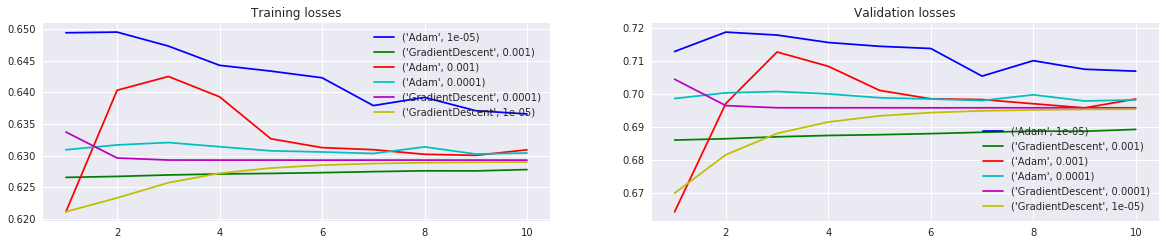

In [18]:
with open("results_dict_conv0.p", "rb") as f:
  results_dict_conv0 = pickle.load(f)

# Plot the training history
x = np.arange(1, 11)

# Plot the training losses
plt.figure(figsize = (20,8))
colors = ["b", "g", "r", "c", "m", "y"]
i = 0
plt.subplot(2, 2, 1)
plt.title("Training losses")
for setup in results_dict_conv0:
  train_losses = results_dict_conv0[setup][2]
  plt.plot(x, train_losses, c=colors[i], label=setup)
  i += 1
plt.legend()

# Plot the validation losses
i = 0
plt.subplot(2, 2, 2)
plt.title("Validation losses")
for setup in results_dict_conv0:
  train_losses = results_dict_conv0[setup][0]
  plt.plot(x, train_losses, c=colors[i], label=setup)
  i += 1
plt.legend()
plt.show() 

It seems that learning rate and optimizer choice doesn't make much differennce in terms of performance

Train the network and get test logits

In [ ]:
learning_rate = 0.001
batch_size = 16
test_batch_size = 16
n_epochs = 30
log = True

# Define the graph
# Basic constants
n = train_images.shape[0]
steps = n // batch_size

# Define placeholders
x = tf.placeholder("float", [None, 224, 224, 3])
y = tf.placeholder("float", [None, 2])

# Define model predictions and corresponding cost
pred = conv_net0(x, weights, biases)
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=pred, labels=y))

# Define optimizer
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

# Get array of correct predictions
correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))

# Get the accuracy
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Initialize the variables
init = tf.global_variables_initializer()

# Run the session
gpu_options = tf.GPUOptions(allow_growth=True)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
sess.run(init)

# Define performance lists
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Define temporary array for storing test test logits
n_test = test_images.shape[0]
test_logits = np.zeros((n_test, 2), dtype=np.float32)

# Iterate over epochs
for epoch in range(n_epochs):
    tep0 = time.time()
    # Iterate over batches
    for batch in range(steps):
        tb0 = time.time()
        # Get batch data
        batch_x = train_images[batch * batch_size:min((batch + 1) * batch_size, n)]
        batch_y = train_labels[batch * batch_size:min((batch + 1) * batch_size, n)]
        # Compute loss and batch accuracy
        _, loss, acc = sess.run([optimizer, cost, accuracy], feed_dict = {x: batch_x,
                                                                         y: batch_y})
        tb1 = time.time()
        print("Epoch {0}, Batch {1}, time: {2}, loss: {3}, accuracy: {4}".format(
            epoch, batch, tb1 - tb0, loss, acc))
    # Feed validation data into network and get the performance
    val_loss, val_acc = sess.run([cost,accuracy], feed_dict={x: validation_images,
                                                         y : validation_labels})
    # Update performance lists
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    train_losses.append(loss)
    train_accuracies.append(acc)

    tep1 = time.time()

    # Report after epoch
    if log:
        print("********************************************")
        print("Epoch {0}, time: {1}, loss: {2}, accuracy: {3}".format(
                epoch, tep1 - tep0, val_loss, val_acc))
        print("********************************************")
        
# After the training is complete, feed thethe test data into network and get logits
test_steps = n_test // test_batch_size
for batch in range(test_steps):
  tb0 = time.time()
  # Get batch data
  test_batch_x = test_images[batch * test_batch_size:min((batch + 1) * test_batch_size, n_test)]
  # Compute batch logits
  logits = sess.run(pred, feed_dict={x: test_batch_x})
  # Update test logits storage variable
  test_logits[batch * test_batch_size:min((batch + 1) * batch_size, n_test)] = logits
  
# Close the session after all epochs
sess.close()
# Save training history
res_dict = {"val_losses": val_losses,
           "val_accs": val_accuracies,
           "train_losses": train_losses,
           "train_accs": train_accuracies}
with open("conv0_gdescent_0_000001_history.p", "wb") as f:
  pickle.dump(res_dict, f)
# Save logits
print()
print("Saving logits")
np.save("conv0_gdescent_0_000001_final_logits.npy", test_logits)
print("Finished")

### Convolutional neural network with dropouts
We will add dropout layers to the model to account for potential overfitting. Since dropout doesn't change the actutal shapes of the tensors, weights dictionary can stay the same.

In [12]:
def conv_net1(x, weights, biases, dropout_rate=0.5):
    """Convolutional neural network with three convolutional layers and two fully connected layers
    with ReLu activation. Pooling is applied after each convolutional layer. Dropout is applied 
    after second and last convolutional layer
    """
    # Apply the first convolutional layer to the input
    conv1 = conv2d(x, weights["wc1"], biases["bc1"])
    # Down sampling with max pooling
    conv1 = maxpool2d(conv1, k=2)
    
    # Apply the second convolutional layer to the ouptut of the first one
    conv2 = conv2d(conv1, weights["wc2"], biases["bc2"])
    # Apply dropout
    conv2 = tf.nn.dropout(conv2, dropout_rate)
    # Down sampling with max pooling
    conv2 = maxpool2d(conv2, k=2)
    
    # Last convolutional layer
    conv3 = conv2d(conv2, weights["wc3"], biases["bc3"])
    conv3 = tf.nn.dropout(conv3, dropout_rate)
    conv3 = maxpool2d(conv3, k=2)
    
    # First fully connected layer
    # Flatten the last convolutional layer
    flat1 = tf.contrib.layers.flatten(conv3)
    fc1 = tf.add(tf.matmul(flat1, weights["wd1"]), biases["bd1"])
    fc1 = tf.nn.relu(fc1)
    
    # Second fully connected layer
    fc2 = tf.add(tf.matmul(fc1, weights["wd2"]), biases["bd2"])
    fc2 = tf.nn.relu(fc2)
    
    # Output, class prediction 
    # output = tf.nn.softmax(tf.add(tf.matmul(fc2, weights['out']), biases['out']))
    output = tf.add(tf.matmul(fc2, weights['out']), biases['out'])
    return output

Train and get the test logits

In [12]:
learning_rate = 0.001
batch_size = 16
test_batch_size = 16
n_epochs = 30
log = True

# Define the graph
# Basic constants
n = train_images.shape[0]
steps = n // batch_size

# Define placeholders
x = tf.placeholder("float", [None, 224, 224, 3])
y = tf.placeholder("float", [None, 2])

# Define model predictions and corresponding cost
pred = conv_net1(x, weights, biases)
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=pred, labels=y))

# Define optimizer
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

# Get array of correct predictions
correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))

# Get the accuracy
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Initialize the variables
init = tf.global_variables_initializer()

# Run the session
gpu_options = tf.GPUOptions(allow_growth=True)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
sess.run(init)

# Define performance lists
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Define temporary array for storing test test logits
n_test = test_images.shape[0]
test_logits = np.zeros((n_test, 2), dtype=np.float32)

# Iterate over epochs
for epoch in range(n_epochs):
    tep0 = time.time()
    # Iterate over batches
    for batch in range(steps):
        tb0 = time.time()
        # Get batch data
        batch_x = train_images[batch * batch_size:min((batch + 1) * batch_size, n)]
        batch_y = train_labels[batch * batch_size:min((batch + 1) * batch_size, n)]
        # Compute loss and batch accuracy
        _, loss, acc = sess.run([optimizer, cost, accuracy], feed_dict = {x: batch_x,
                                                                         y: batch_y})
        tb1 = time.time()
        print("Epoch {0}, Batch {1}, time: {2}, loss: {3}, accuracy: {4}".format(
            epoch, batch, tb1 - tb0, loss, acc))
    # Feed validation data into network and get the performance
    val_loss, val_acc = sess.run([cost,accuracy], feed_dict={x: validation_images,
                                                         y : validation_labels})
    # Update performance lists
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    train_losses.append(loss)
    train_accuracies.append(acc)

    tep1 = time.time()

    # Report after epoch
    if log:
        print("********************************************")
        print("Epoch {0}, time: {1}, loss: {2}, accuracy: {3}".format(
                epoch, tep1 - tep0, val_loss, val_acc))
        print("********************************************")
# After the training is complete, feed thethe test data into network and get logits
test_steps = n_test // test_batch_size
for batch in range(test_steps):
  tb0 = time.time()
  # Get batch data
  test_batch_x = test_images[batch * test_batch_size:min((batch + 1) * test_batch_size, n_test)]
  # Compute batch logits
  logits = sess.run(pred, feed_dict={x: test_batch_x})
  # Update test logits storage variable
  test_logits[batch * test_batch_size:min((batch + 1) * batch_size, n_test)] = logits
  
# Close the session after all epochs
sess.close()
# Save training history
res_dict = {"val_losses": val_losses,
           "val_accs": val_accuracies,
           "train_losses": train_losses,
           "train_accs": train_accuracies}
with open("conv1_gdescent_0_000001_history.p", "wb") as f:
  pickle.dump(res_dict, f)
# Save logits
print()
print("Saving logits")
np.save("conv1_gdescent_0_000001_final_logits.npy", test_logits)
print("Finished")

Epoch 0, Batch 0, time: 1.4061226844787598, loss: 0.7166409492492676, accuracy: 0.4375
Epoch 0, Batch 1, time: 0.15652179718017578, loss: 1.6231273412704468, accuracy: 0.625
Epoch 0, Batch 2, time: 0.13627314567565918, loss: 0.6433502435684204, accuracy: 0.6875
Epoch 0, Batch 3, time: 0.12670445442199707, loss: 0.6063251495361328, accuracy: 0.6875
Epoch 0, Batch 4, time: 0.11827635765075684, loss: 0.5832306146621704, accuracy: 0.75
Epoch 0, Batch 5, time: 0.11359524726867676, loss: 0.30093657970428467, accuracy: 0.9375
Epoch 0, Batch 6, time: 0.11028766632080078, loss: 0.3835570514202118, accuracy: 0.875
Epoch 0, Batch 7, time: 0.10582423210144043, loss: 0.884964108467102, accuracy: 0.625
Epoch 0, Batch 8, time: 0.10533428192138672, loss: 0.6884514093399048, accuracy: 0.4375
Epoch 0, Batch 9, time: 0.10802435874938965, loss: 0.4248656928539276, accuracy: 0.875
Epoch 0, Batch 10, time: 0.1065056324005127, loss: 0.8662517666816711, accuracy: 0.625
Epoch 0, Batch 11, time: 0.1062359809875

Epoch 0, Batch 95, time: 0.2160496711730957, loss: 0.6592144966125488, accuracy: 0.625
Epoch 0, Batch 96, time: 1.005866289138794, loss: 0.48908525705337524, accuracy: 0.9375
Epoch 0, Batch 97, time: 0.18132328987121582, loss: 0.6497626304626465, accuracy: 0.6875
Epoch 0, Batch 98, time: 0.15842556953430176, loss: 0.4228556752204895, accuracy: 0.875
Epoch 0, Batch 99, time: 0.1862163543701172, loss: 0.5787353515625, accuracy: 0.75
Epoch 0, Batch 100, time: 0.1751084327697754, loss: 0.5492388010025024, accuracy: 0.75
Epoch 0, Batch 101, time: 0.17788267135620117, loss: 0.4891079366207123, accuracy: 0.8125
Epoch 0, Batch 102, time: 0.16783785820007324, loss: 0.6593628525733948, accuracy: 0.6875
Epoch 0, Batch 103, time: 0.19701790809631348, loss: 0.5700356364250183, accuracy: 0.75
Epoch 0, Batch 104, time: 1.1206185817718506, loss: 0.5036568641662598, accuracy: 0.8125
Epoch 0, Batch 105, time: 0.23561882972717285, loss: 0.6573048233985901, accuracy: 0.6875
Epoch 0, Batch 106, time: 0.149

Epoch 0, Batch 189, time: 0.18956589698791504, loss: 0.592629075050354, accuracy: 0.75
Epoch 0, Batch 190, time: 0.2586066722869873, loss: 0.4894344210624695, accuracy: 0.8125
Epoch 0, Batch 191, time: 1.0289690494537354, loss: 0.570838451385498, accuracy: 0.75
Epoch 0, Batch 192, time: 0.23199009895324707, loss: 0.5584797859191895, accuracy: 0.75
Epoch 0, Batch 193, time: 0.1749255657196045, loss: 0.6354814171791077, accuracy: 0.6875
Epoch 0, Batch 194, time: 0.1696312427520752, loss: 0.6227874159812927, accuracy: 0.6875
Epoch 0, Batch 195, time: 0.20194792747497559, loss: 0.6632370948791504, accuracy: 0.625
Epoch 0, Batch 196, time: 0.1824047565460205, loss: 0.5985361337661743, accuracy: 0.75
Epoch 0, Batch 197, time: 0.605323314666748, loss: 0.567294716835022, accuracy: 0.75
Epoch 0, Batch 198, time: 0.8555755615234375, loss: 0.4946046471595764, accuracy: 0.8125
Epoch 0, Batch 199, time: 0.2230360507965088, loss: 0.40876901149749756, accuracy: 0.875
Epoch 0, Batch 200, time: 0.19205

Epoch 0, Batch 282, time: 0.20539569854736328, loss: 0.7741521596908569, accuracy: 0.625
Epoch 0, Batch 283, time: 0.25065112113952637, loss: 0.5587463974952698, accuracy: 0.75
Epoch 0, Batch 284, time: 0.40386462211608887, loss: 0.34761250019073486, accuracy: 0.9375
Epoch 0, Batch 285, time: 0.46940135955810547, loss: 0.6728293895721436, accuracy: 0.6875
Epoch 0, Batch 286, time: 0.16103005409240723, loss: 0.8042817115783691, accuracy: 0.5625
Epoch 0, Batch 287, time: 0.2780444622039795, loss: 0.5255485773086548, accuracy: 0.8125
Epoch 0, Batch 288, time: 0.3674905300140381, loss: 0.6274134516716003, accuracy: 0.6875
Epoch 0, Batch 289, time: 0.2426455020904541, loss: 0.5194410085678101, accuracy: 0.8125
Epoch 0, Batch 290, time: 0.18404245376586914, loss: 0.4881913661956787, accuracy: 0.8125
Epoch 0, Batch 291, time: 0.16649889945983887, loss: 0.483988881111145, accuracy: 0.8125
Epoch 0, Batch 292, time: 0.26258015632629395, loss: 0.4795605540275574, accuracy: 0.8125
Epoch 0, Batch 2

Epoch 1, Batch 49, time: 0.10434079170227051, loss: 0.7567700743675232, accuracy: 0.5
Epoch 1, Batch 50, time: 0.10559511184692383, loss: 0.6831077933311462, accuracy: 0.5625
Epoch 1, Batch 51, time: 0.10662412643432617, loss: 0.6093140840530396, accuracy: 0.8125
Epoch 1, Batch 52, time: 0.10854005813598633, loss: 0.6238834857940674, accuracy: 0.6875
Epoch 1, Batch 53, time: 0.106292724609375, loss: 0.629210352897644, accuracy: 0.6875
Epoch 1, Batch 54, time: 0.1060781478881836, loss: 0.6267872452735901, accuracy: 0.6875
Epoch 1, Batch 55, time: 0.10620617866516113, loss: 0.5746511220932007, accuracy: 0.75
Epoch 1, Batch 56, time: 0.10541558265686035, loss: 0.4489600658416748, accuracy: 0.875
Epoch 1, Batch 57, time: 0.10663008689880371, loss: 0.40769869089126587, accuracy: 0.875
Epoch 1, Batch 58, time: 0.10457372665405273, loss: 0.6460850238800049, accuracy: 0.6875
Epoch 1, Batch 59, time: 0.10711359977722168, loss: 0.5555089712142944, accuracy: 0.75
Epoch 1, Batch 60, time: 0.105812

Epoch 1, Batch 142, time: 0.10723614692687988, loss: 0.4961172342300415, accuracy: 0.8125
Epoch 1, Batch 143, time: 0.10594487190246582, loss: 0.48958060145378113, accuracy: 0.8125
Epoch 1, Batch 144, time: 0.10614490509033203, loss: 0.7979421615600586, accuracy: 0.5625
Epoch 1, Batch 145, time: 0.10622310638427734, loss: 0.6327142715454102, accuracy: 0.6875
Epoch 1, Batch 146, time: 0.10590839385986328, loss: 0.5163401365280151, accuracy: 0.8125
Epoch 1, Batch 147, time: 0.10485458374023438, loss: 0.6860519647598267, accuracy: 0.625
Epoch 1, Batch 148, time: 0.10772967338562012, loss: 0.40689557790756226, accuracy: 0.9375
Epoch 1, Batch 149, time: 0.10653328895568848, loss: 0.48082831501960754, accuracy: 0.8125
Epoch 1, Batch 150, time: 0.10757040977478027, loss: 0.3279019594192505, accuracy: 0.9375
Epoch 1, Batch 151, time: 0.10997724533081055, loss: 0.4858032763004303, accuracy: 0.8125
Epoch 1, Batch 152, time: 0.10649657249450684, loss: 0.38916921615600586, accuracy: 0.875
Epoch 1,

Epoch 1, Batch 236, time: 0.11080598831176758, loss: 0.5636386275291443, accuracy: 0.75
Epoch 1, Batch 237, time: 0.10677456855773926, loss: 0.5685806274414062, accuracy: 0.75
Epoch 1, Batch 238, time: 0.10558748245239258, loss: 0.4960061311721802, accuracy: 0.8125
Epoch 1, Batch 239, time: 0.10580825805664062, loss: 0.5658192038536072, accuracy: 0.75
Epoch 1, Batch 240, time: 0.1052544116973877, loss: 0.6251188516616821, accuracy: 0.6875
Epoch 1, Batch 241, time: 0.10467028617858887, loss: 0.49952465295791626, accuracy: 0.8125
Epoch 1, Batch 242, time: 0.10700297355651855, loss: 0.6204160451889038, accuracy: 0.6875
Epoch 1, Batch 243, time: 0.10475611686706543, loss: 0.7461611032485962, accuracy: 0.5625
Epoch 1, Batch 244, time: 0.10729646682739258, loss: 0.5596913695335388, accuracy: 0.75
Epoch 1, Batch 245, time: 0.10654187202453613, loss: 0.5308062434196472, accuracy: 0.8125
Epoch 1, Batch 246, time: 0.10662126541137695, loss: 0.755912184715271, accuracy: 0.5625
Epoch 1, Batch 247,

Epoch 2, Batch 4, time: 0.10651564598083496, loss: 0.5833026766777039, accuracy: 0.75
Epoch 2, Batch 5, time: 0.10608100891113281, loss: 0.38963979482650757, accuracy: 0.9375
Epoch 2, Batch 6, time: 0.10701704025268555, loss: 0.3994404673576355, accuracy: 0.875
Epoch 2, Batch 7, time: 0.10619759559631348, loss: 0.7467747330665588, accuracy: 0.625
Epoch 2, Batch 8, time: 0.10666275024414062, loss: 0.6364684700965881, accuracy: 0.6875
Epoch 2, Batch 9, time: 0.10684633255004883, loss: 0.4377453923225403, accuracy: 0.875
Epoch 2, Batch 10, time: 0.1061251163482666, loss: 0.7100939750671387, accuracy: 0.625
Epoch 2, Batch 11, time: 0.1068260669708252, loss: 0.4310094714164734, accuracy: 0.875
Epoch 2, Batch 12, time: 0.10564637184143066, loss: 0.8749401569366455, accuracy: 0.5
Epoch 2, Batch 13, time: 0.10608243942260742, loss: 0.6710900068283081, accuracy: 0.625
Epoch 2, Batch 14, time: 0.10724902153015137, loss: 0.4792569875717163, accuracy: 0.875
Epoch 2, Batch 15, time: 0.1053645610809

Epoch 2, Batch 98, time: 0.1069345474243164, loss: 0.4359471797943115, accuracy: 0.875
Epoch 2, Batch 99, time: 0.10583734512329102, loss: 0.558493971824646, accuracy: 0.75
Epoch 2, Batch 100, time: 0.10640239715576172, loss: 0.5728302001953125, accuracy: 0.75
Epoch 2, Batch 101, time: 0.10454511642456055, loss: 0.4869239628314972, accuracy: 0.8125
Epoch 2, Batch 102, time: 0.10635161399841309, loss: 0.6360595226287842, accuracy: 0.6875
Epoch 2, Batch 103, time: 0.10512757301330566, loss: 0.5567543506622314, accuracy: 0.75
Epoch 2, Batch 104, time: 0.1065514087677002, loss: 0.4989085793495178, accuracy: 0.8125
Epoch 2, Batch 105, time: 0.10340499877929688, loss: 0.6341013312339783, accuracy: 0.6875
Epoch 2, Batch 106, time: 0.10322165489196777, loss: 0.7006133794784546, accuracy: 0.625
Epoch 2, Batch 107, time: 0.10608172416687012, loss: 0.5566869974136353, accuracy: 0.75
Epoch 2, Batch 108, time: 0.10808014869689941, loss: 0.5640623569488525, accuracy: 0.75
Epoch 2, Batch 109, time: 0

Epoch 2, Batch 191, time: 0.10730814933776855, loss: 0.5668647885322571, accuracy: 0.75
Epoch 2, Batch 192, time: 0.10413670539855957, loss: 0.5600594282150269, accuracy: 0.75
Epoch 2, Batch 193, time: 0.10704445838928223, loss: 0.6382158994674683, accuracy: 0.6875
Epoch 2, Batch 194, time: 0.10539674758911133, loss: 0.6350475549697876, accuracy: 0.6875
Epoch 2, Batch 195, time: 0.1058964729309082, loss: 0.68974369764328, accuracy: 0.625
Epoch 2, Batch 196, time: 0.10684943199157715, loss: 0.5684093236923218, accuracy: 0.75
Epoch 2, Batch 197, time: 0.10787415504455566, loss: 0.5697481632232666, accuracy: 0.75
Epoch 2, Batch 198, time: 0.10602712631225586, loss: 0.5078369975090027, accuracy: 0.8125
Epoch 2, Batch 199, time: 0.10737776756286621, loss: 0.4263419210910797, accuracy: 0.875
Epoch 2, Batch 200, time: 0.10466170310974121, loss: 0.39350610971450806, accuracy: 0.875
Epoch 2, Batch 201, time: 0.10751008987426758, loss: 0.5623406171798706, accuracy: 0.75
Epoch 2, Batch 202, time:

Epoch 2, Batch 284, time: 0.11066627502441406, loss: 0.341145396232605, accuracy: 0.9375
Epoch 2, Batch 285, time: 0.10541486740112305, loss: 0.6371129751205444, accuracy: 0.6875
Epoch 2, Batch 286, time: 0.10632085800170898, loss: 0.7933719158172607, accuracy: 0.5625
Epoch 2, Batch 287, time: 0.10487055778503418, loss: 0.5060004591941833, accuracy: 0.8125
Epoch 2, Batch 288, time: 0.10694169998168945, loss: 0.6312065720558167, accuracy: 0.6875
Epoch 2, Batch 289, time: 0.1050562858581543, loss: 0.5066144466400146, accuracy: 0.8125
Epoch 2, Batch 290, time: 0.10721325874328613, loss: 0.4910345673561096, accuracy: 0.8125
Epoch 2, Batch 291, time: 0.10514116287231445, loss: 0.4949913024902344, accuracy: 0.8125
Epoch 2, Batch 292, time: 0.10790657997131348, loss: 0.48499196767807007, accuracy: 0.8125
Epoch 2, Batch 293, time: 0.10597968101501465, loss: 0.5764044523239136, accuracy: 0.75
Epoch 2, Batch 294, time: 0.10571479797363281, loss: 0.5699034929275513, accuracy: 0.75
Epoch 2, Batch 

Epoch 3, Batch 52, time: 0.10604095458984375, loss: 0.6145222187042236, accuracy: 0.6875
Epoch 3, Batch 53, time: 0.10474276542663574, loss: 0.6151596307754517, accuracy: 0.6875
Epoch 3, Batch 54, time: 0.10640263557434082, loss: 0.619368314743042, accuracy: 0.6875
Epoch 3, Batch 55, time: 0.1036992073059082, loss: 0.5771731734275818, accuracy: 0.75
Epoch 3, Batch 56, time: 0.10295486450195312, loss: 0.4622892737388611, accuracy: 0.875
Epoch 3, Batch 57, time: 0.10617303848266602, loss: 0.4350471794605255, accuracy: 0.875
Epoch 3, Batch 58, time: 0.10378456115722656, loss: 0.640521764755249, accuracy: 0.6875
Epoch 3, Batch 59, time: 0.1116642951965332, loss: 0.5637789964675903, accuracy: 0.75
Epoch 3, Batch 60, time: 0.10618209838867188, loss: 0.6918350458145142, accuracy: 0.625
Epoch 3, Batch 61, time: 0.10658812522888184, loss: 0.7445388436317444, accuracy: 0.5625
Epoch 3, Batch 62, time: 0.10562801361083984, loss: 0.5222865343093872, accuracy: 0.8125
Epoch 3, Batch 63, time: 0.10704

Epoch 3, Batch 145, time: 0.10862135887145996, loss: 0.6237396001815796, accuracy: 0.6875
Epoch 3, Batch 146, time: 0.10507678985595703, loss: 0.4987092614173889, accuracy: 0.8125
Epoch 3, Batch 147, time: 0.1065363883972168, loss: 0.7005892992019653, accuracy: 0.625
Epoch 3, Batch 148, time: 0.1056358814239502, loss: 0.3925693929195404, accuracy: 0.9375
Epoch 3, Batch 149, time: 0.10718297958374023, loss: 0.48726335167884827, accuracy: 0.8125
Epoch 3, Batch 150, time: 0.10486793518066406, loss: 0.339228093624115, accuracy: 0.9375
Epoch 3, Batch 151, time: 0.10675597190856934, loss: 0.4887329936027527, accuracy: 0.8125
Epoch 3, Batch 152, time: 0.10600566864013672, loss: 0.39171016216278076, accuracy: 0.875
Epoch 3, Batch 153, time: 0.10644817352294922, loss: 0.3891076147556305, accuracy: 0.875
Epoch 3, Batch 154, time: 0.10654520988464355, loss: 0.7698923349380493, accuracy: 0.625
Epoch 3, Batch 155, time: 0.10538411140441895, loss: 0.6508024334907532, accuracy: 0.6875
Epoch 3, Batch 

Epoch 3, Batch 237, time: 0.10652279853820801, loss: 0.5683715343475342, accuracy: 0.75
Epoch 3, Batch 238, time: 0.10571551322937012, loss: 0.5032714009284973, accuracy: 0.8125
Epoch 3, Batch 239, time: 0.10662150382995605, loss: 0.566482663154602, accuracy: 0.75
Epoch 3, Batch 240, time: 0.10738182067871094, loss: 0.6284993886947632, accuracy: 0.6875
Epoch 3, Batch 241, time: 0.10560011863708496, loss: 0.4938070476055145, accuracy: 0.8125
Epoch 3, Batch 242, time: 0.1074056625366211, loss: 0.62511146068573, accuracy: 0.6875
Epoch 3, Batch 243, time: 0.10696864128112793, loss: 0.765042781829834, accuracy: 0.5625
Epoch 3, Batch 244, time: 0.1065359115600586, loss: 0.5782120227813721, accuracy: 0.75
Epoch 3, Batch 245, time: 0.10596489906311035, loss: 0.5143128633499146, accuracy: 0.8125
Epoch 3, Batch 246, time: 0.10376787185668945, loss: 0.748566746711731, accuracy: 0.5625
Epoch 3, Batch 247, time: 0.10370731353759766, loss: 0.7413727641105652, accuracy: 0.5625
Epoch 3, Batch 248, tim

Epoch 4, Batch 5, time: 0.10663414001464844, loss: 0.38509899377822876, accuracy: 0.9375
Epoch 4, Batch 6, time: 0.10546588897705078, loss: 0.40712979435920715, accuracy: 0.875
Epoch 4, Batch 7, time: 0.10664749145507812, loss: 0.7323563694953918, accuracy: 0.625
Epoch 4, Batch 8, time: 0.10469484329223633, loss: 0.6333780288696289, accuracy: 0.6875
Epoch 4, Batch 9, time: 0.10712504386901855, loss: 0.42877352237701416, accuracy: 0.875
Epoch 4, Batch 10, time: 0.10509872436523438, loss: 0.6948946714401245, accuracy: 0.625
Epoch 4, Batch 11, time: 0.11479306221008301, loss: 0.4279090166091919, accuracy: 0.875
Epoch 4, Batch 12, time: 0.10713863372802734, loss: 0.8605215549468994, accuracy: 0.5
Epoch 4, Batch 13, time: 0.10612320899963379, loss: 0.6925361156463623, accuracy: 0.625
Epoch 4, Batch 14, time: 0.10582613945007324, loss: 0.4595051109790802, accuracy: 0.875
Epoch 4, Batch 15, time: 0.10776638984680176, loss: 0.6305636167526245, accuracy: 0.6875
Epoch 4, Batch 16, time: 0.104951

Epoch 4, Batch 98, time: 0.10706353187561035, loss: 0.443489670753479, accuracy: 0.875
Epoch 4, Batch 99, time: 0.10415053367614746, loss: 0.562343418598175, accuracy: 0.75
Epoch 4, Batch 100, time: 0.10307693481445312, loss: 0.5660561323165894, accuracy: 0.75
Epoch 4, Batch 101, time: 0.10729527473449707, loss: 0.4940941333770752, accuracy: 0.8125
Epoch 4, Batch 102, time: 0.10770821571350098, loss: 0.6287330389022827, accuracy: 0.6875
Epoch 4, Batch 103, time: 0.10692787170410156, loss: 0.557063639163971, accuracy: 0.75
Epoch 4, Batch 104, time: 0.10557842254638672, loss: 0.5007827281951904, accuracy: 0.8125
Epoch 4, Batch 105, time: 0.10627293586730957, loss: 0.6386659741401672, accuracy: 0.6875
Epoch 4, Batch 106, time: 0.10435891151428223, loss: 0.6955868005752563, accuracy: 0.625
Epoch 4, Batch 107, time: 0.10723447799682617, loss: 0.5719062089920044, accuracy: 0.75
Epoch 4, Batch 108, time: 0.10493779182434082, loss: 0.5624518990516663, accuracy: 0.75
Epoch 4, Batch 109, time: 0

Epoch 4, Batch 191, time: 0.10774612426757812, loss: 0.5607888698577881, accuracy: 0.75
Epoch 4, Batch 192, time: 0.10618877410888672, loss: 0.5638250112533569, accuracy: 0.75
Epoch 4, Batch 193, time: 0.10627412796020508, loss: 0.6400398015975952, accuracy: 0.6875
Epoch 4, Batch 194, time: 0.1049184799194336, loss: 0.628262996673584, accuracy: 0.6875
Epoch 4, Batch 195, time: 0.10690164566040039, loss: 0.7024156451225281, accuracy: 0.625
Epoch 4, Batch 196, time: 0.10589861869812012, loss: 0.5694601535797119, accuracy: 0.75
Epoch 4, Batch 197, time: 0.10718798637390137, loss: 0.564373791217804, accuracy: 0.75
Epoch 4, Batch 198, time: 0.10451984405517578, loss: 0.502768874168396, accuracy: 0.8125
Epoch 4, Batch 199, time: 0.10305428504943848, loss: 0.4277666211128235, accuracy: 0.875
Epoch 4, Batch 200, time: 0.10802888870239258, loss: 0.41186025738716125, accuracy: 0.875
Epoch 4, Batch 201, time: 0.10290718078613281, loss: 0.560875654220581, accuracy: 0.75
Epoch 4, Batch 202, time: 0

Epoch 4, Batch 283, time: 0.10714292526245117, loss: 0.5605853796005249, accuracy: 0.75
Epoch 4, Batch 284, time: 0.10774469375610352, loss: 0.35194313526153564, accuracy: 0.9375
Epoch 4, Batch 285, time: 0.10610342025756836, loss: 0.6409742832183838, accuracy: 0.6875
Epoch 4, Batch 286, time: 0.10454893112182617, loss: 0.7880920171737671, accuracy: 0.5625
Epoch 4, Batch 287, time: 0.10718512535095215, loss: 0.5024162530899048, accuracy: 0.8125
Epoch 4, Batch 288, time: 0.10508537292480469, loss: 0.6338354349136353, accuracy: 0.6875
Epoch 4, Batch 289, time: 0.10744404792785645, loss: 0.5048795342445374, accuracy: 0.8125
Epoch 4, Batch 290, time: 0.10510778427124023, loss: 0.500231921672821, accuracy: 0.8125
Epoch 4, Batch 291, time: 0.11003255844116211, loss: 0.49614423513412476, accuracy: 0.8125
Epoch 4, Batch 292, time: 0.10504817962646484, loss: 0.4928145408630371, accuracy: 0.8125
Epoch 4, Batch 293, time: 0.10748648643493652, loss: 0.5600592494010925, accuracy: 0.75
Epoch 4, Batc

Epoch 5, Batch 51, time: 0.10783791542053223, loss: 0.544155478477478, accuracy: 0.8125
Epoch 5, Batch 52, time: 0.10535287857055664, loss: 0.6185042262077332, accuracy: 0.6875
Epoch 5, Batch 53, time: 0.10758423805236816, loss: 0.6243828535079956, accuracy: 0.6875
Epoch 5, Batch 54, time: 0.10374593734741211, loss: 0.6240640878677368, accuracy: 0.6875
Epoch 5, Batch 55, time: 0.10825467109680176, loss: 0.5771222114562988, accuracy: 0.75
Epoch 5, Batch 56, time: 0.10539436340332031, loss: 0.4709039330482483, accuracy: 0.875
Epoch 5, Batch 57, time: 0.10748672485351562, loss: 0.4457951784133911, accuracy: 0.875
Epoch 5, Batch 58, time: 0.10612821578979492, loss: 0.6246073246002197, accuracy: 0.6875
Epoch 5, Batch 59, time: 0.10683798789978027, loss: 0.56889808177948, accuracy: 0.75
Epoch 5, Batch 60, time: 0.1054835319519043, loss: 0.6840113401412964, accuracy: 0.625
Epoch 5, Batch 61, time: 0.1079566478729248, loss: 0.7368819117546082, accuracy: 0.5625
Epoch 5, Batch 62, time: 0.105724

Epoch 5, Batch 145, time: 0.10778474807739258, loss: 0.6179193258285522, accuracy: 0.6875
Epoch 5, Batch 146, time: 0.10487198829650879, loss: 0.5062344074249268, accuracy: 0.8125
Epoch 5, Batch 147, time: 0.10649299621582031, loss: 0.6957138180732727, accuracy: 0.625
Epoch 5, Batch 148, time: 0.10539746284484863, loss: 0.3863583505153656, accuracy: 0.9375
Epoch 5, Batch 149, time: 0.10749006271362305, loss: 0.4903418719768524, accuracy: 0.8125
Epoch 5, Batch 150, time: 0.10477590560913086, loss: 0.35150641202926636, accuracy: 0.9375
Epoch 5, Batch 151, time: 0.10732150077819824, loss: 0.4853624701499939, accuracy: 0.8125
Epoch 5, Batch 152, time: 0.10446810722351074, loss: 0.40213578939437866, accuracy: 0.875
Epoch 5, Batch 153, time: 0.10769152641296387, loss: 0.3997306227684021, accuracy: 0.875
Epoch 5, Batch 154, time: 0.1022953987121582, loss: 0.7632272243499756, accuracy: 0.625
Epoch 5, Batch 155, time: 0.11094975471496582, loss: 0.6424351930618286, accuracy: 0.6875
Epoch 5, Batc

Epoch 5, Batch 238, time: 0.10709786415100098, loss: 0.5052006244659424, accuracy: 0.8125
Epoch 5, Batch 239, time: 0.10371065139770508, loss: 0.5606915950775146, accuracy: 0.75
Epoch 5, Batch 240, time: 0.10290932655334473, loss: 0.6291161775588989, accuracy: 0.6875
Epoch 5, Batch 241, time: 0.1063690185546875, loss: 0.5065249800682068, accuracy: 0.8125
Epoch 5, Batch 242, time: 0.10641646385192871, loss: 0.6300559043884277, accuracy: 0.6875
Epoch 5, Batch 243, time: 0.1072237491607666, loss: 0.7542490363121033, accuracy: 0.5625
Epoch 5, Batch 244, time: 0.1055912971496582, loss: 0.5730916857719421, accuracy: 0.75
Epoch 5, Batch 245, time: 0.10616016387939453, loss: 0.510495126247406, accuracy: 0.8125
Epoch 5, Batch 246, time: 0.10468530654907227, loss: 0.7512069940567017, accuracy: 0.5625
Epoch 5, Batch 247, time: 0.10623478889465332, loss: 0.7274550795555115, accuracy: 0.5625
Epoch 5, Batch 248, time: 0.1039888858795166, loss: 0.6264044046401978, accuracy: 0.6875
Epoch 5, Batch 249,

Epoch 6, Batch 5, time: 0.10722732543945312, loss: 0.3839681148529053, accuracy: 0.9375
Epoch 6, Batch 6, time: 0.1052846908569336, loss: 0.41096898913383484, accuracy: 0.875
Epoch 6, Batch 7, time: 0.10710978507995605, loss: 0.7212371230125427, accuracy: 0.625
Epoch 6, Batch 8, time: 0.10387468338012695, loss: 0.6391685009002686, accuracy: 0.6875
Epoch 6, Batch 9, time: 0.10675835609436035, loss: 0.4288025498390198, accuracy: 0.875
Epoch 6, Batch 10, time: 0.10389900207519531, loss: 0.7154052257537842, accuracy: 0.625
Epoch 6, Batch 11, time: 0.1034705638885498, loss: 0.43620818853378296, accuracy: 0.875
Epoch 6, Batch 12, time: 0.10720419883728027, loss: 0.8483245372772217, accuracy: 0.5
Epoch 6, Batch 13, time: 0.1045072078704834, loss: 0.6837952136993408, accuracy: 0.625
Epoch 6, Batch 14, time: 0.10712981224060059, loss: 0.4536195397377014, accuracy: 0.875
Epoch 6, Batch 15, time: 0.1040034294128418, loss: 0.625827968120575, accuracy: 0.6875
Epoch 6, Batch 16, time: 0.107031822204

Epoch 6, Batch 100, time: 0.10625791549682617, loss: 0.5555311441421509, accuracy: 0.75
Epoch 6, Batch 101, time: 0.1043250560760498, loss: 0.5062105655670166, accuracy: 0.8125
Epoch 6, Batch 102, time: 0.10726642608642578, loss: 0.640606164932251, accuracy: 0.6875
Epoch 6, Batch 103, time: 0.10610222816467285, loss: 0.5569031238555908, accuracy: 0.75
Epoch 6, Batch 104, time: 0.1059713363647461, loss: 0.4972642660140991, accuracy: 0.8125
Epoch 6, Batch 105, time: 0.1049659252166748, loss: 0.6359298825263977, accuracy: 0.6875
Epoch 6, Batch 106, time: 0.10697269439697266, loss: 0.6984931826591492, accuracy: 0.625
Epoch 6, Batch 107, time: 0.10507988929748535, loss: 0.5594885349273682, accuracy: 0.75
Epoch 6, Batch 108, time: 0.10733318328857422, loss: 0.569233238697052, accuracy: 0.75
Epoch 6, Batch 109, time: 0.10474205017089844, loss: 0.4328840672969818, accuracy: 0.875
Epoch 6, Batch 110, time: 0.1074521541595459, loss: 0.4270191788673401, accuracy: 0.875
Epoch 6, Batch 111, time: 0

Epoch 6, Batch 192, time: 0.10726284980773926, loss: 0.5576562881469727, accuracy: 0.75
Epoch 6, Batch 193, time: 0.11200404167175293, loss: 0.6437132358551025, accuracy: 0.6875
Epoch 6, Batch 194, time: 0.10578298568725586, loss: 0.6425721645355225, accuracy: 0.6875
Epoch 6, Batch 195, time: 0.10476326942443848, loss: 0.693649172782898, accuracy: 0.625
Epoch 6, Batch 196, time: 0.10697388648986816, loss: 0.5607975721359253, accuracy: 0.75
Epoch 6, Batch 197, time: 0.10234308242797852, loss: 0.5645023584365845, accuracy: 0.75
Epoch 6, Batch 198, time: 0.10310935974121094, loss: 0.4953292906284332, accuracy: 0.8125
Epoch 6, Batch 199, time: 0.11135077476501465, loss: 0.4219393730163574, accuracy: 0.875
Epoch 6, Batch 200, time: 0.10521697998046875, loss: 0.4134565591812134, accuracy: 0.875
Epoch 6, Batch 201, time: 0.10686445236206055, loss: 0.5716793537139893, accuracy: 0.75
Epoch 6, Batch 202, time: 0.10461664199829102, loss: 0.5647289752960205, accuracy: 0.75
Epoch 6, Batch 203, time

Epoch 6, Batch 284, time: 0.1078181266784668, loss: 0.34722423553466797, accuracy: 0.9375
Epoch 6, Batch 285, time: 0.10592055320739746, loss: 0.6465823650360107, accuracy: 0.6875
Epoch 6, Batch 286, time: 0.10965752601623535, loss: 0.7867889404296875, accuracy: 0.5625
Epoch 6, Batch 287, time: 0.10573863983154297, loss: 0.4975438714027405, accuracy: 0.8125
Epoch 6, Batch 288, time: 0.10643148422241211, loss: 0.6345092058181763, accuracy: 0.6875
Epoch 6, Batch 289, time: 0.1055457592010498, loss: 0.4948421120643616, accuracy: 0.8125
Epoch 6, Batch 290, time: 0.10729742050170898, loss: 0.4923851490020752, accuracy: 0.8125
Epoch 6, Batch 291, time: 0.10599374771118164, loss: 0.4905380606651306, accuracy: 0.8125
Epoch 6, Batch 292, time: 0.10785174369812012, loss: 0.490970253944397, accuracy: 0.8125
Epoch 6, Batch 293, time: 0.10638165473937988, loss: 0.563628077507019, accuracy: 0.75
Epoch 6, Batch 294, time: 0.10733294486999512, loss: 0.5592225193977356, accuracy: 0.75
Epoch 6, Batch 29

Epoch 7, Batch 52, time: 0.11078739166259766, loss: 0.6238070726394653, accuracy: 0.6875
Epoch 7, Batch 53, time: 0.10586071014404297, loss: 0.6224353313446045, accuracy: 0.6875
Epoch 7, Batch 54, time: 0.10582113265991211, loss: 0.6220250129699707, accuracy: 0.6875
Epoch 7, Batch 55, time: 0.10439181327819824, loss: 0.576187014579773, accuracy: 0.75
Epoch 7, Batch 56, time: 0.10761213302612305, loss: 0.46379029750823975, accuracy: 0.875
Epoch 7, Batch 57, time: 0.10609173774719238, loss: 0.4555453658103943, accuracy: 0.875
Epoch 7, Batch 58, time: 0.10671567916870117, loss: 0.6294374465942383, accuracy: 0.6875
Epoch 7, Batch 59, time: 0.10704207420349121, loss: 0.562866747379303, accuracy: 0.75
Epoch 7, Batch 60, time: 0.10903644561767578, loss: 0.6944969296455383, accuracy: 0.625
Epoch 7, Batch 61, time: 0.10649371147155762, loss: 0.7364203929901123, accuracy: 0.5625
Epoch 7, Batch 62, time: 0.10563826560974121, loss: 0.5192227959632874, accuracy: 0.8125
Epoch 7, Batch 63, time: 0.10

Epoch 7, Batch 147, time: 0.10724163055419922, loss: 0.6877928972244263, accuracy: 0.625
Epoch 7, Batch 148, time: 0.10473155975341797, loss: 0.38364070653915405, accuracy: 0.9375
Epoch 7, Batch 149, time: 0.10776543617248535, loss: 0.500691294670105, accuracy: 0.8125
Epoch 7, Batch 150, time: 0.10521841049194336, loss: 0.34624171257019043, accuracy: 0.9375
Epoch 7, Batch 151, time: 0.10671401023864746, loss: 0.4911496639251709, accuracy: 0.8125
Epoch 7, Batch 152, time: 0.10453557968139648, loss: 0.4061174988746643, accuracy: 0.875
Epoch 7, Batch 153, time: 0.10664844512939453, loss: 0.39081811904907227, accuracy: 0.875
Epoch 7, Batch 154, time: 0.10511302947998047, loss: 0.7472324967384338, accuracy: 0.625
Epoch 7, Batch 155, time: 0.10691380500793457, loss: 0.640630304813385, accuracy: 0.6875
Epoch 7, Batch 156, time: 0.10461163520812988, loss: 0.41321682929992676, accuracy: 0.875
Epoch 7, Batch 157, time: 0.10346555709838867, loss: 0.6421338319778442, accuracy: 0.6875
Epoch 7, Batc

Epoch 7, Batch 240, time: 0.10652828216552734, loss: 0.6295745372772217, accuracy: 0.6875
Epoch 7, Batch 241, time: 0.10483288764953613, loss: 0.4990248680114746, accuracy: 0.8125
Epoch 7, Batch 242, time: 0.10633087158203125, loss: 0.6283824443817139, accuracy: 0.6875
Epoch 7, Batch 243, time: 0.10451126098632812, loss: 0.7545967102050781, accuracy: 0.5625
Epoch 7, Batch 244, time: 0.10641288757324219, loss: 0.5616667866706848, accuracy: 0.75
Epoch 7, Batch 245, time: 0.10277533531188965, loss: 0.5076665282249451, accuracy: 0.8125
Epoch 7, Batch 246, time: 0.10338568687438965, loss: 0.7441532611846924, accuracy: 0.5625
Epoch 7, Batch 247, time: 0.10585331916809082, loss: 0.7310652732849121, accuracy: 0.5625
Epoch 7, Batch 248, time: 0.10732388496398926, loss: 0.6183258295059204, accuracy: 0.6875
Epoch 7, Batch 249, time: 0.10669732093811035, loss: 0.524129331111908, accuracy: 0.8125
Epoch 7, Batch 250, time: 0.10342574119567871, loss: 0.6770679950714111, accuracy: 0.625
Epoch 7, Batch

Epoch 8, Batch 8, time: 0.10680532455444336, loss: 0.637735903263092, accuracy: 0.6875
Epoch 8, Batch 9, time: 0.10515451431274414, loss: 0.43073010444641113, accuracy: 0.875
Epoch 8, Batch 10, time: 0.10687446594238281, loss: 0.7039657235145569, accuracy: 0.625
Epoch 8, Batch 11, time: 0.10407805442810059, loss: 0.4234440326690674, accuracy: 0.875
Epoch 8, Batch 12, time: 0.10710477828979492, loss: 0.8438941836357117, accuracy: 0.5
Epoch 8, Batch 13, time: 0.1040964126586914, loss: 0.6849542856216431, accuracy: 0.625
Epoch 8, Batch 14, time: 0.10702967643737793, loss: 0.45401763916015625, accuracy: 0.875
Epoch 8, Batch 15, time: 0.10414934158325195, loss: 0.6329858303070068, accuracy: 0.6875
Epoch 8, Batch 16, time: 0.10628032684326172, loss: 0.43840014934539795, accuracy: 0.875
Epoch 8, Batch 17, time: 0.10487818717956543, loss: 0.6324491500854492, accuracy: 0.6875
Epoch 8, Batch 18, time: 0.10601997375488281, loss: 0.5037973523139954, accuracy: 0.8125
Epoch 8, Batch 19, time: 0.1039

Epoch 8, Batch 102, time: 0.11353039741516113, loss: 0.6310681104660034, accuracy: 0.6875
Epoch 8, Batch 103, time: 0.10546374320983887, loss: 0.5616177916526794, accuracy: 0.75
Epoch 8, Batch 104, time: 0.10720586776733398, loss: 0.4937216639518738, accuracy: 0.8125
Epoch 8, Batch 105, time: 0.10521340370178223, loss: 0.6345254182815552, accuracy: 0.6875
Epoch 8, Batch 106, time: 0.10695028305053711, loss: 0.6952130198478699, accuracy: 0.625
Epoch 8, Batch 107, time: 0.10471844673156738, loss: 0.5652930736541748, accuracy: 0.75
Epoch 8, Batch 108, time: 0.10774016380310059, loss: 0.560650110244751, accuracy: 0.75
Epoch 8, Batch 109, time: 0.10485005378723145, loss: 0.43567290902137756, accuracy: 0.875
Epoch 8, Batch 110, time: 0.10786008834838867, loss: 0.4188873767852783, accuracy: 0.875
Epoch 8, Batch 111, time: 0.10548067092895508, loss: 0.8498184680938721, accuracy: 0.5
Epoch 8, Batch 112, time: 0.10602831840515137, loss: 0.49617999792099, accuracy: 0.8125
Epoch 8, Batch 113, time

Epoch 8, Batch 194, time: 0.10898518562316895, loss: 0.6401493549346924, accuracy: 0.6875
Epoch 8, Batch 195, time: 0.10628342628479004, loss: 0.7076643109321594, accuracy: 0.625
Epoch 8, Batch 196, time: 0.10737323760986328, loss: 0.5671730041503906, accuracy: 0.75
Epoch 8, Batch 197, time: 0.10485029220581055, loss: 0.5541975498199463, accuracy: 0.75
Epoch 8, Batch 198, time: 0.1061553955078125, loss: 0.49751877784729004, accuracy: 0.8125
Epoch 8, Batch 199, time: 0.1041109561920166, loss: 0.42083635926246643, accuracy: 0.875
Epoch 8, Batch 200, time: 0.10303807258605957, loss: 0.41463613510131836, accuracy: 0.875
Epoch 8, Batch 201, time: 0.10809135437011719, loss: 0.5676710605621338, accuracy: 0.75
Epoch 8, Batch 202, time: 0.10449600219726562, loss: 0.5625764727592468, accuracy: 0.75
Epoch 8, Batch 203, time: 0.10735321044921875, loss: 0.568354070186615, accuracy: 0.75
Epoch 8, Batch 204, time: 0.1051332950592041, loss: 0.7834113836288452, accuracy: 0.5625
Epoch 8, Batch 205, time

Epoch 8, Batch 288, time: 0.10595536231994629, loss: 0.6230129599571228, accuracy: 0.6875
Epoch 8, Batch 289, time: 0.10296130180358887, loss: 0.49768465757369995, accuracy: 0.8125
Epoch 8, Batch 290, time: 0.10302495956420898, loss: 0.4912317991256714, accuracy: 0.8125
Epoch 8, Batch 291, time: 0.10676217079162598, loss: 0.4871058166027069, accuracy: 0.8125
Epoch 8, Batch 292, time: 0.10513687133789062, loss: 0.4889342784881592, accuracy: 0.8125
Epoch 8, Batch 293, time: 0.1073148250579834, loss: 0.5610325336456299, accuracy: 0.75
Epoch 8, Batch 294, time: 0.1040642261505127, loss: 0.5592795610427856, accuracy: 0.75
Epoch 8, Batch 295, time: 0.10413289070129395, loss: 0.3429441750049591, accuracy: 0.9375
Epoch 8, Batch 296, time: 0.10933089256286621, loss: 0.5668897032737732, accuracy: 0.75
Epoch 8, Batch 297, time: 0.10578441619873047, loss: 0.6474599242210388, accuracy: 0.6875
Epoch 8, Batch 298, time: 0.1044931411743164, loss: 0.5609583258628845, accuracy: 0.75
Epoch 8, Batch 299, 

Epoch 9, Batch 56, time: 0.10783648490905762, loss: 0.4660874009132385, accuracy: 0.875
Epoch 9, Batch 57, time: 0.10393810272216797, loss: 0.44987672567367554, accuracy: 0.875
Epoch 9, Batch 58, time: 0.11150956153869629, loss: 0.6224780082702637, accuracy: 0.6875
Epoch 9, Batch 59, time: 0.10451531410217285, loss: 0.5552550554275513, accuracy: 0.75
Epoch 9, Batch 60, time: 0.10785722732543945, loss: 0.6856061220169067, accuracy: 0.625
Epoch 9, Batch 61, time: 0.10514092445373535, loss: 0.7436045408248901, accuracy: 0.5625
Epoch 9, Batch 62, time: 0.10787391662597656, loss: 0.5164487361907959, accuracy: 0.8125
Epoch 9, Batch 63, time: 0.10586404800415039, loss: 0.5070691704750061, accuracy: 0.8125
Epoch 9, Batch 64, time: 0.10712695121765137, loss: 0.6820411682128906, accuracy: 0.625
Epoch 9, Batch 65, time: 0.105987548828125, loss: 0.5074013471603394, accuracy: 0.8125
Epoch 9, Batch 66, time: 0.10693979263305664, loss: 0.5606909394264221, accuracy: 0.75
Epoch 9, Batch 67, time: 0.105

Epoch 9, Batch 151, time: 0.10762619972229004, loss: 0.49113044142723083, accuracy: 0.8125
Epoch 9, Batch 152, time: 0.10296773910522461, loss: 0.4063139855861664, accuracy: 0.875
Epoch 9, Batch 153, time: 0.10365772247314453, loss: 0.39408594369888306, accuracy: 0.875
Epoch 9, Batch 154, time: 0.10658526420593262, loss: 0.7402197122573853, accuracy: 0.625
Epoch 9, Batch 155, time: 0.10492777824401855, loss: 0.6523175239562988, accuracy: 0.6875
Epoch 9, Batch 156, time: 0.10754084587097168, loss: 0.4220392107963562, accuracy: 0.875
Epoch 9, Batch 157, time: 0.10588431358337402, loss: 0.6441254615783691, accuracy: 0.6875
Epoch 9, Batch 158, time: 0.10681343078613281, loss: 0.49139997363090515, accuracy: 0.8125
Epoch 9, Batch 159, time: 0.10720539093017578, loss: 0.6465110778808594, accuracy: 0.6875
Epoch 9, Batch 160, time: 0.10536003112792969, loss: 0.5636863708496094, accuracy: 0.75
Epoch 9, Batch 161, time: 0.10539937019348145, loss: 0.41602933406829834, accuracy: 0.875
Epoch 9, Batc

Epoch 9, Batch 244, time: 0.10653543472290039, loss: 0.5660029649734497, accuracy: 0.75
Epoch 9, Batch 245, time: 0.1059422492980957, loss: 0.5064170360565186, accuracy: 0.8125
Epoch 9, Batch 246, time: 0.10521841049194336, loss: 0.7477096319198608, accuracy: 0.5625
Epoch 9, Batch 247, time: 0.10488724708557129, loss: 0.7281544208526611, accuracy: 0.5625
Epoch 9, Batch 248, time: 0.10556411743164062, loss: 0.6242483258247375, accuracy: 0.6875
Epoch 9, Batch 249, time: 0.10322141647338867, loss: 0.5307987928390503, accuracy: 0.8125
Epoch 9, Batch 250, time: 0.1034543514251709, loss: 0.6798795461654663, accuracy: 0.625
Epoch 9, Batch 251, time: 0.10707259178161621, loss: 0.513164222240448, accuracy: 0.8125
Epoch 9, Batch 252, time: 0.10312056541442871, loss: 0.50077885389328, accuracy: 0.8125
Epoch 9, Batch 253, time: 0.10337495803833008, loss: 0.6825551390647888, accuracy: 0.625
Epoch 9, Batch 254, time: 0.10671830177307129, loss: 0.6273102760314941, accuracy: 0.6875
Epoch 9, Batch 255,

Epoch 10, Batch 12, time: 0.10620951652526855, loss: 0.8440201878547668, accuracy: 0.5
Epoch 10, Batch 13, time: 0.10290694236755371, loss: 0.6810709238052368, accuracy: 0.625
Epoch 10, Batch 14, time: 0.10293960571289062, loss: 0.4501152038574219, accuracy: 0.875
Epoch 10, Batch 15, time: 0.10679435729980469, loss: 0.6247704029083252, accuracy: 0.6875
Epoch 10, Batch 16, time: 0.10672163963317871, loss: 0.4401244521141052, accuracy: 0.875
Epoch 10, Batch 17, time: 0.10723209381103516, loss: 0.6293243169784546, accuracy: 0.6875
Epoch 10, Batch 18, time: 0.10413241386413574, loss: 0.4996313154697418, accuracy: 0.8125
Epoch 10, Batch 19, time: 0.10804510116577148, loss: 0.5620747804641724, accuracy: 0.75
Epoch 10, Batch 20, time: 0.10719180107116699, loss: 0.6997041702270508, accuracy: 0.625
Epoch 10, Batch 21, time: 0.1075432300567627, loss: 0.6296871900558472, accuracy: 0.6875
Epoch 10, Batch 22, time: 0.10501813888549805, loss: 0.6273424625396729, accuracy: 0.6875
Epoch 10, Batch 23, 

Epoch 10, Batch 105, time: 0.111602783203125, loss: 0.6312224268913269, accuracy: 0.6875
Epoch 10, Batch 106, time: 0.10513639450073242, loss: 0.6952749490737915, accuracy: 0.625
Epoch 10, Batch 107, time: 0.10698270797729492, loss: 0.5631922483444214, accuracy: 0.75
Epoch 10, Batch 108, time: 0.10490703582763672, loss: 0.5576801300048828, accuracy: 0.75
Epoch 10, Batch 109, time: 0.10725045204162598, loss: 0.4360787570476532, accuracy: 0.875
Epoch 10, Batch 110, time: 0.10456442832946777, loss: 0.42417582869529724, accuracy: 0.875
Epoch 10, Batch 111, time: 0.10361576080322266, loss: 0.8596795201301575, accuracy: 0.5
Epoch 10, Batch 112, time: 0.11014962196350098, loss: 0.4949437975883484, accuracy: 0.8125
Epoch 10, Batch 113, time: 0.10584187507629395, loss: 0.6291776299476624, accuracy: 0.6875
Epoch 10, Batch 114, time: 0.10775566101074219, loss: 0.6222519278526306, accuracy: 0.6875
Epoch 10, Batch 115, time: 0.1056673526763916, loss: 0.502273440361023, accuracy: 0.8125
Epoch 10, Ba

Epoch 10, Batch 197, time: 0.1077415943145752, loss: 0.5653290748596191, accuracy: 0.75
Epoch 10, Batch 198, time: 0.10535430908203125, loss: 0.494009792804718, accuracy: 0.8125
Epoch 10, Batch 199, time: 0.10727715492248535, loss: 0.4236569404602051, accuracy: 0.875
Epoch 10, Batch 200, time: 0.10760354995727539, loss: 0.4161171317100525, accuracy: 0.875
Epoch 10, Batch 201, time: 0.10753560066223145, loss: 0.560693621635437, accuracy: 0.75
Epoch 10, Batch 202, time: 0.10467863082885742, loss: 0.5641319751739502, accuracy: 0.75
Epoch 10, Batch 203, time: 0.1068723201751709, loss: 0.5655746459960938, accuracy: 0.75
Epoch 10, Batch 204, time: 0.10391926765441895, loss: 0.7881946563720703, accuracy: 0.5625
Epoch 10, Batch 205, time: 0.1032419204711914, loss: 0.6274501085281372, accuracy: 0.6875
Epoch 10, Batch 206, time: 0.10591721534729004, loss: 0.6885778903961182, accuracy: 0.625
Epoch 10, Batch 207, time: 0.10483288764953613, loss: 0.6896054744720459, accuracy: 0.625
Epoch 10, Batch 

Epoch 10, Batch 288, time: 0.10825228691101074, loss: 0.6307175159454346, accuracy: 0.6875
Epoch 10, Batch 289, time: 0.10427570343017578, loss: 0.49551641941070557, accuracy: 0.8125
Epoch 10, Batch 290, time: 0.10756731033325195, loss: 0.49641335010528564, accuracy: 0.8125
Epoch 10, Batch 291, time: 0.10434699058532715, loss: 0.4858507812023163, accuracy: 0.8125
Epoch 10, Batch 292, time: 0.10741662979125977, loss: 0.4885193109512329, accuracy: 0.8125
Epoch 10, Batch 293, time: 0.10469841957092285, loss: 0.5622408390045166, accuracy: 0.75
Epoch 10, Batch 294, time: 0.10739850997924805, loss: 0.5714722275733948, accuracy: 0.75
Epoch 10, Batch 295, time: 0.1049196720123291, loss: 0.34321707487106323, accuracy: 0.9375
Epoch 10, Batch 296, time: 0.10700321197509766, loss: 0.5606926679611206, accuracy: 0.75
Epoch 10, Batch 297, time: 0.10489368438720703, loss: 0.6482514142990112, accuracy: 0.6875
Epoch 10, Batch 298, time: 0.10633206367492676, loss: 0.5658280253410339, accuracy: 0.75
Epoch

Epoch 11, Batch 56, time: 0.10531353950500488, loss: 0.4674025774002075, accuracy: 0.875
Epoch 11, Batch 57, time: 0.10698318481445312, loss: 0.45117923617362976, accuracy: 0.875
Epoch 11, Batch 58, time: 0.10777783393859863, loss: 0.6247395277023315, accuracy: 0.6875
Epoch 11, Batch 59, time: 0.10566186904907227, loss: 0.568289041519165, accuracy: 0.75
Epoch 11, Batch 60, time: 0.10620522499084473, loss: 0.6925028562545776, accuracy: 0.625
Epoch 11, Batch 61, time: 0.10452532768249512, loss: 0.7380589246749878, accuracy: 0.5625
Epoch 11, Batch 62, time: 0.10721087455749512, loss: 0.5182816982269287, accuracy: 0.8125
Epoch 11, Batch 63, time: 0.10454487800598145, loss: 0.5027697682380676, accuracy: 0.8125
Epoch 11, Batch 64, time: 0.10796642303466797, loss: 0.6806999444961548, accuracy: 0.625
Epoch 11, Batch 65, time: 0.10617232322692871, loss: 0.5013437271118164, accuracy: 0.8125
Epoch 11, Batch 66, time: 0.10719132423400879, loss: 0.5626171827316284, accuracy: 0.75
Epoch 11, Batch 67

Epoch 11, Batch 149, time: 0.10808920860290527, loss: 0.493835985660553, accuracy: 0.8125
Epoch 11, Batch 150, time: 0.10625863075256348, loss: 0.35839787125587463, accuracy: 0.9375
Epoch 11, Batch 151, time: 0.10731315612792969, loss: 0.49013078212738037, accuracy: 0.8125
Epoch 11, Batch 152, time: 0.10500025749206543, loss: 0.4103250503540039, accuracy: 0.875
Epoch 11, Batch 153, time: 0.10721373558044434, loss: 0.4042518734931946, accuracy: 0.875
Epoch 11, Batch 154, time: 0.10446691513061523, loss: 0.7354221343994141, accuracy: 0.625
Epoch 11, Batch 155, time: 0.10443496704101562, loss: 0.6400080323219299, accuracy: 0.6875
Epoch 11, Batch 156, time: 0.10726809501647949, loss: 0.4153152406215668, accuracy: 0.875
Epoch 11, Batch 157, time: 0.10298466682434082, loss: 0.6376622915267944, accuracy: 0.6875
Epoch 11, Batch 158, time: 0.10306620597839355, loss: 0.4834142327308655, accuracy: 0.8125
Epoch 11, Batch 159, time: 0.10672545433044434, loss: 0.6409454941749573, accuracy: 0.6875
Ep

Epoch 11, Batch 241, time: 0.1068720817565918, loss: 0.49812203645706177, accuracy: 0.8125
Epoch 11, Batch 242, time: 0.10663628578186035, loss: 0.6211708784103394, accuracy: 0.6875
Epoch 11, Batch 243, time: 0.10613298416137695, loss: 0.7472660541534424, accuracy: 0.5625
Epoch 11, Batch 244, time: 0.10509037971496582, loss: 0.5631002187728882, accuracy: 0.75
Epoch 11, Batch 245, time: 0.10767269134521484, loss: 0.5003345608711243, accuracy: 0.8125
Epoch 11, Batch 246, time: 0.10434460639953613, loss: 0.7500807046890259, accuracy: 0.5625
Epoch 11, Batch 247, time: 0.1082308292388916, loss: 0.730551540851593, accuracy: 0.5625
Epoch 11, Batch 248, time: 0.10472536087036133, loss: 0.6223560571670532, accuracy: 0.6875
Epoch 11, Batch 249, time: 0.11050009727478027, loss: 0.5190944671630859, accuracy: 0.8125
Epoch 11, Batch 250, time: 0.10491490364074707, loss: 0.675433337688446, accuracy: 0.625
Epoch 11, Batch 251, time: 0.10769319534301758, loss: 0.5177406072616577, accuracy: 0.8125
Epoch

Epoch 12, Batch 7, time: 0.1068730354309082, loss: 0.7094950079917908, accuracy: 0.625
Epoch 12, Batch 8, time: 0.10608530044555664, loss: 0.6358292102813721, accuracy: 0.6875
Epoch 12, Batch 9, time: 0.1144406795501709, loss: 0.43437862396240234, accuracy: 0.875
Epoch 12, Batch 10, time: 0.10545539855957031, loss: 0.7063407897949219, accuracy: 0.625
Epoch 12, Batch 11, time: 0.11091923713684082, loss: 0.4296002984046936, accuracy: 0.875
Epoch 12, Batch 12, time: 0.10525083541870117, loss: 0.8509175777435303, accuracy: 0.5
Epoch 12, Batch 13, time: 0.10787105560302734, loss: 0.7027460336685181, accuracy: 0.625
Epoch 12, Batch 14, time: 0.10412716865539551, loss: 0.4489119052886963, accuracy: 0.875
Epoch 12, Batch 15, time: 0.10739850997924805, loss: 0.6345982551574707, accuracy: 0.6875
Epoch 12, Batch 16, time: 0.10471081733703613, loss: 0.4329335689544678, accuracy: 0.875
Epoch 12, Batch 17, time: 0.1074514389038086, loss: 0.6303291320800781, accuracy: 0.6875
Epoch 12, Batch 18, time:

Epoch 12, Batch 100, time: 0.10812044143676758, loss: 0.5634053945541382, accuracy: 0.75
Epoch 12, Batch 101, time: 0.10502457618713379, loss: 0.49709439277648926, accuracy: 0.8125
Epoch 12, Batch 102, time: 0.10759425163269043, loss: 0.6331112384796143, accuracy: 0.6875
Epoch 12, Batch 103, time: 0.10552620887756348, loss: 0.5621182918548584, accuracy: 0.75
Epoch 12, Batch 104, time: 0.10651826858520508, loss: 0.4981568455696106, accuracy: 0.8125
Epoch 12, Batch 105, time: 0.10396289825439453, loss: 0.6301007866859436, accuracy: 0.6875
Epoch 12, Batch 106, time: 0.10773849487304688, loss: 0.6948097944259644, accuracy: 0.625
Epoch 12, Batch 107, time: 0.10445451736450195, loss: 0.5537493228912354, accuracy: 0.75
Epoch 12, Batch 108, time: 0.1067354679107666, loss: 0.5685418844223022, accuracy: 0.75
Epoch 12, Batch 109, time: 0.10525703430175781, loss: 0.43502718210220337, accuracy: 0.875
Epoch 12, Batch 110, time: 0.1045236587524414, loss: 0.4267238676548004, accuracy: 0.875
Epoch 12, 

Epoch 12, Batch 192, time: 0.10757899284362793, loss: 0.5650580525398254, accuracy: 0.75
Epoch 12, Batch 193, time: 0.10768580436706543, loss: 0.6377837657928467, accuracy: 0.6875
Epoch 12, Batch 194, time: 0.10682511329650879, loss: 0.6405463218688965, accuracy: 0.6875
Epoch 12, Batch 195, time: 0.10405564308166504, loss: 0.7090317010879517, accuracy: 0.625
Epoch 12, Batch 196, time: 0.10649847984313965, loss: 0.5620824098587036, accuracy: 0.75
Epoch 12, Batch 197, time: 0.10409402847290039, loss: 0.5643921494483948, accuracy: 0.75
Epoch 12, Batch 198, time: 0.10642170906066895, loss: 0.49531489610671997, accuracy: 0.8125
Epoch 12, Batch 199, time: 0.1040346622467041, loss: 0.42470285296440125, accuracy: 0.875
Epoch 12, Batch 200, time: 0.10405611991882324, loss: 0.4207633137702942, accuracy: 0.875
Epoch 12, Batch 201, time: 0.10821914672851562, loss: 0.5596863031387329, accuracy: 0.75
Epoch 12, Batch 202, time: 0.10671281814575195, loss: 0.5654461979866028, accuracy: 0.75
Epoch 12, B

Epoch 12, Batch 283, time: 0.10713338851928711, loss: 0.5640866756439209, accuracy: 0.75
Epoch 12, Batch 284, time: 0.10560178756713867, loss: 0.35538342595100403, accuracy: 0.9375
Epoch 12, Batch 285, time: 0.10583877563476562, loss: 0.6378000974655151, accuracy: 0.6875
Epoch 12, Batch 286, time: 0.10528206825256348, loss: 0.784599781036377, accuracy: 0.5625
Epoch 12, Batch 287, time: 0.10511994361877441, loss: 0.4997367262840271, accuracy: 0.8125
Epoch 12, Batch 288, time: 0.10363078117370605, loss: 0.6355708837509155, accuracy: 0.6875
Epoch 12, Batch 289, time: 0.10289263725280762, loss: 0.4970592260360718, accuracy: 0.8125
Epoch 12, Batch 290, time: 0.1076974868774414, loss: 0.49719947576522827, accuracy: 0.8125
Epoch 12, Batch 291, time: 0.10533928871154785, loss: 0.48722848296165466, accuracy: 0.8125
Epoch 12, Batch 292, time: 0.10235786437988281, loss: 0.49606263637542725, accuracy: 0.8125
Epoch 12, Batch 293, time: 0.10270333290100098, loss: 0.5590424537658691, accuracy: 0.75
E

Epoch 13, Batch 49, time: 0.10660815238952637, loss: 0.7978511452674866, accuracy: 0.5
Epoch 13, Batch 50, time: 0.10425710678100586, loss: 0.7287127375602722, accuracy: 0.5625
Epoch 13, Batch 51, time: 0.10660290718078613, loss: 0.5194831490516663, accuracy: 0.8125
Epoch 13, Batch 52, time: 0.10655403137207031, loss: 0.6229840517044067, accuracy: 0.6875
Epoch 13, Batch 53, time: 0.10497283935546875, loss: 0.62458735704422, accuracy: 0.6875
Epoch 13, Batch 54, time: 0.10697007179260254, loss: 0.6197696924209595, accuracy: 0.6875
Epoch 13, Batch 55, time: 0.10681533813476562, loss: 0.5756425857543945, accuracy: 0.75
Epoch 13, Batch 56, time: 0.10422754287719727, loss: 0.456991970539093, accuracy: 0.875
Epoch 13, Batch 57, time: 0.10622739791870117, loss: 0.4493526816368103, accuracy: 0.875
Epoch 13, Batch 58, time: 0.10185599327087402, loss: 0.6238797903060913, accuracy: 0.6875
Epoch 13, Batch 59, time: 0.10142683982849121, loss: 0.5557353496551514, accuracy: 0.75
Epoch 13, Batch 60, ti

Epoch 13, Batch 142, time: 0.10766935348510742, loss: 0.4943851828575134, accuracy: 0.8125
Epoch 13, Batch 143, time: 0.10566949844360352, loss: 0.4976390600204468, accuracy: 0.8125
Epoch 13, Batch 144, time: 0.10774803161621094, loss: 0.7715306878089905, accuracy: 0.5625
Epoch 13, Batch 145, time: 0.10797524452209473, loss: 0.6262202262878418, accuracy: 0.6875
Epoch 13, Batch 146, time: 0.1049814224243164, loss: 0.5068440437316895, accuracy: 0.8125
Epoch 13, Batch 147, time: 0.1054389476776123, loss: 0.6843687891960144, accuracy: 0.625
Epoch 13, Batch 148, time: 0.10786628723144531, loss: 0.3805784583091736, accuracy: 0.9375
Epoch 13, Batch 149, time: 0.10557079315185547, loss: 0.4963342845439911, accuracy: 0.8125
Epoch 13, Batch 150, time: 0.10728788375854492, loss: 0.3526909351348877, accuracy: 0.9375
Epoch 13, Batch 151, time: 0.10412359237670898, loss: 0.49005621671676636, accuracy: 0.8125
Epoch 13, Batch 152, time: 0.10853338241577148, loss: 0.4133036434650421, accuracy: 0.875
Ep

Epoch 13, Batch 233, time: 0.10375285148620605, loss: 0.7540290355682373, accuracy: 0.5625
Epoch 13, Batch 234, time: 0.10608744621276855, loss: 0.6899275779724121, accuracy: 0.625
Epoch 13, Batch 235, time: 0.10344219207763672, loss: 0.568209707736969, accuracy: 0.75
Epoch 13, Batch 236, time: 0.11134862899780273, loss: 0.5635761022567749, accuracy: 0.75
Epoch 13, Batch 237, time: 0.10516953468322754, loss: 0.565406858921051, accuracy: 0.75
Epoch 13, Batch 238, time: 0.10530400276184082, loss: 0.5051403641700745, accuracy: 0.8125
Epoch 13, Batch 239, time: 0.1074516773223877, loss: 0.5679587721824646, accuracy: 0.75
Epoch 13, Batch 240, time: 0.10563778877258301, loss: 0.6258635520935059, accuracy: 0.6875
Epoch 13, Batch 241, time: 0.1075143814086914, loss: 0.5017364025115967, accuracy: 0.8125
Epoch 13, Batch 242, time: 0.10615181922912598, loss: 0.6292312145233154, accuracy: 0.6875
Epoch 13, Batch 243, time: 0.10654711723327637, loss: 0.7468340396881104, accuracy: 0.5625
Epoch 13, Ba

Epoch 14, Batch 0, time: 0.10438728332519531, loss: 0.36915260553359985, accuracy: 0.9375
Epoch 14, Batch 1, time: 0.10547566413879395, loss: 0.7048404812812805, accuracy: 0.625
Epoch 14, Batch 2, time: 0.10631251335144043, loss: 0.6376105546951294, accuracy: 0.6875
Epoch 14, Batch 3, time: 0.1050105094909668, loss: 0.6282795667648315, accuracy: 0.6875
Epoch 14, Batch 4, time: 0.10674858093261719, loss: 0.5627210140228271, accuracy: 0.75
Epoch 14, Batch 5, time: 0.10306358337402344, loss: 0.3717191219329834, accuracy: 0.9375
Epoch 14, Batch 6, time: 0.10448455810546875, loss: 0.41929247975349426, accuracy: 0.875
Epoch 14, Batch 7, time: 0.11092567443847656, loss: 0.7086600065231323, accuracy: 0.625
Epoch 14, Batch 8, time: 0.1043093204498291, loss: 0.638613224029541, accuracy: 0.6875
Epoch 14, Batch 9, time: 0.10742783546447754, loss: 0.43026798963546753, accuracy: 0.875
Epoch 14, Batch 10, time: 0.10506558418273926, loss: 0.7066752910614014, accuracy: 0.625
Epoch 14, Batch 11, time: 0

Epoch 14, Batch 93, time: 0.10948944091796875, loss: 0.774222731590271, accuracy: 0.5625
Epoch 14, Batch 94, time: 0.10837507247924805, loss: 0.6930628418922424, accuracy: 0.625
Epoch 14, Batch 95, time: 0.10904288291931152, loss: 0.6809210777282715, accuracy: 0.625
Epoch 14, Batch 96, time: 0.10470342636108398, loss: 0.3893609046936035, accuracy: 0.9375
Epoch 14, Batch 97, time: 0.10722708702087402, loss: 0.6246184706687927, accuracy: 0.6875
Epoch 14, Batch 98, time: 0.1043698787689209, loss: 0.43826377391815186, accuracy: 0.875
Epoch 14, Batch 99, time: 0.10719513893127441, loss: 0.5656476020812988, accuracy: 0.75
Epoch 14, Batch 100, time: 0.10491180419921875, loss: 0.5632899403572083, accuracy: 0.75
Epoch 14, Batch 101, time: 0.1070859432220459, loss: 0.49556076526641846, accuracy: 0.8125
Epoch 14, Batch 102, time: 0.1056206226348877, loss: 0.6436059474945068, accuracy: 0.6875
Epoch 14, Batch 103, time: 0.10597848892211914, loss: 0.5640538930892944, accuracy: 0.75
Epoch 14, Batch 1

Epoch 14, Batch 185, time: 0.1076817512512207, loss: 0.7198271751403809, accuracy: 0.625
Epoch 14, Batch 186, time: 0.10577583312988281, loss: 0.49284279346466064, accuracy: 0.8125
Epoch 14, Batch 187, time: 0.10588407516479492, loss: 0.4906967282295227, accuracy: 0.8125
Epoch 14, Batch 188, time: 0.10590028762817383, loss: 0.33451440930366516, accuracy: 0.9375
Epoch 14, Batch 189, time: 0.10489082336425781, loss: 0.5653353929519653, accuracy: 0.75
Epoch 14, Batch 190, time: 0.10408377647399902, loss: 0.48390746116638184, accuracy: 0.8125
Epoch 14, Batch 191, time: 0.10343384742736816, loss: 0.5625566244125366, accuracy: 0.75
Epoch 14, Batch 192, time: 0.10841631889343262, loss: 0.5699797868728638, accuracy: 0.75
Epoch 14, Batch 193, time: 0.10479474067687988, loss: 0.6389033794403076, accuracy: 0.6875
Epoch 14, Batch 194, time: 0.10759973526000977, loss: 0.6357933282852173, accuracy: 0.6875
Epoch 14, Batch 195, time: 0.10645627975463867, loss: 0.7162366509437561, accuracy: 0.625
Epoch

Epoch 14, Batch 276, time: 0.10684394836425781, loss: 0.505448579788208, accuracy: 0.8125
Epoch 14, Batch 277, time: 0.10551071166992188, loss: 0.6217705011367798, accuracy: 0.6875
Epoch 14, Batch 278, time: 0.10578560829162598, loss: 0.4943920373916626, accuracy: 0.8125
Epoch 14, Batch 279, time: 0.10505890846252441, loss: 0.4906907081604004, accuracy: 0.8125
Epoch 14, Batch 280, time: 0.10601210594177246, loss: 0.5606717467308044, accuracy: 0.75
Epoch 14, Batch 281, time: 0.10451889038085938, loss: 0.35618099570274353, accuracy: 0.9375
Epoch 14, Batch 282, time: 0.1070864200592041, loss: 0.7131212949752808, accuracy: 0.625
Epoch 14, Batch 283, time: 0.10563421249389648, loss: 0.5643496513366699, accuracy: 0.75
Epoch 14, Batch 284, time: 0.10502433776855469, loss: 0.3497840166091919, accuracy: 0.9375
Epoch 14, Batch 285, time: 0.10353207588195801, loss: 0.6418341994285583, accuracy: 0.6875
Epoch 14, Batch 286, time: 0.10337090492248535, loss: 0.7828485369682312, accuracy: 0.5625
Epoch

Epoch 15, Batch 43, time: 0.10826921463012695, loss: 0.5619913339614868, accuracy: 0.75
Epoch 15, Batch 44, time: 0.1075892448425293, loss: 0.6333732604980469, accuracy: 0.6875
Epoch 15, Batch 45, time: 0.10809159278869629, loss: 0.633102297782898, accuracy: 0.6875
Epoch 15, Batch 46, time: 0.10229182243347168, loss: 0.5017510652542114, accuracy: 0.8125
Epoch 15, Batch 47, time: 0.10371518135070801, loss: 0.6842674016952515, accuracy: 0.625
Epoch 15, Batch 48, time: 0.11384034156799316, loss: 0.6912356615066528, accuracy: 0.625
Epoch 15, Batch 49, time: 0.10527563095092773, loss: 0.7967198491096497, accuracy: 0.5
Epoch 15, Batch 50, time: 0.10647368431091309, loss: 0.7231884002685547, accuracy: 0.5625
Epoch 15, Batch 51, time: 0.10615134239196777, loss: 0.525751531124115, accuracy: 0.8125
Epoch 15, Batch 52, time: 0.10766839981079102, loss: 0.6166996955871582, accuracy: 0.6875
Epoch 15, Batch 53, time: 0.1052701473236084, loss: 0.6171468496322632, accuracy: 0.6875
Epoch 15, Batch 54, t

Epoch 15, Batch 136, time: 0.10749936103820801, loss: 0.49851012229919434, accuracy: 0.8125
Epoch 15, Batch 137, time: 0.10538434982299805, loss: 0.6960414052009583, accuracy: 0.625
Epoch 15, Batch 138, time: 0.10679912567138672, loss: 0.5639169216156006, accuracy: 0.75
Epoch 15, Batch 139, time: 0.10481643676757812, loss: 0.8193153142929077, accuracy: 0.5
Epoch 15, Batch 140, time: 0.10702323913574219, loss: 0.4503770172595978, accuracy: 0.875
Epoch 15, Batch 141, time: 0.10466337203979492, loss: 0.5027503967285156, accuracy: 0.8125
Epoch 15, Batch 142, time: 0.10794377326965332, loss: 0.49527424573898315, accuracy: 0.8125
Epoch 15, Batch 143, time: 0.10549426078796387, loss: 0.4979412257671356, accuracy: 0.8125
Epoch 15, Batch 144, time: 0.10741257667541504, loss: 0.7678192257881165, accuracy: 0.5625
Epoch 15, Batch 145, time: 0.1050577163696289, loss: 0.6292069554328918, accuracy: 0.6875
Epoch 15, Batch 146, time: 0.1076803207397461, loss: 0.49792569875717163, accuracy: 0.8125
Epoch

Epoch 15, Batch 227, time: 0.10743355751037598, loss: 0.754840075969696, accuracy: 0.5625
Epoch 15, Batch 228, time: 0.10559654235839844, loss: 0.747478723526001, accuracy: 0.5625
Epoch 15, Batch 229, time: 0.10686302185058594, loss: 0.40298426151275635, accuracy: 0.9375
Epoch 15, Batch 230, time: 0.10493063926696777, loss: 0.6188840866088867, accuracy: 0.6875
Epoch 15, Batch 231, time: 0.10698819160461426, loss: 0.7483656406402588, accuracy: 0.5625
Epoch 15, Batch 232, time: 0.10398387908935547, loss: 0.3432304263114929, accuracy: 1.0
Epoch 15, Batch 233, time: 0.10754776000976562, loss: 0.7621839046478271, accuracy: 0.5625
Epoch 15, Batch 234, time: 0.10477781295776367, loss: 0.6783689260482788, accuracy: 0.625
Epoch 15, Batch 235, time: 0.10312914848327637, loss: 0.5678941011428833, accuracy: 0.75
Epoch 15, Batch 236, time: 0.10814428329467773, loss: 0.5643802881240845, accuracy: 0.75
Epoch 15, Batch 237, time: 0.10515403747558594, loss: 0.5778828263282776, accuracy: 0.75
Epoch 15, 

Epoch 15, Batch 319, time: 0.10811734199523926, loss: 0.6398485898971558, accuracy: 0.6875
Epoch 15, Batch 320, time: 0.10500979423522949, loss: 0.5655932426452637, accuracy: 0.75
Epoch 15, Batch 321, time: 0.106719970703125, loss: 0.6356950998306274, accuracy: 0.6875
Epoch 15, Batch 322, time: 0.10410404205322266, loss: 0.6266871690750122, accuracy: 0.6875
Epoch 15, Batch 323, time: 0.10709714889526367, loss: 0.621371328830719, accuracy: 0.6875
********************************************
Epoch 15, time: 34.48036575317383, loss: 0.6896531581878662, accuracy: 0.625
********************************************
Epoch 16, Batch 0, time: 0.10364985466003418, loss: 0.371310830116272, accuracy: 0.9375
Epoch 16, Batch 1, time: 0.10411286354064941, loss: 0.7056474685668945, accuracy: 0.625
Epoch 16, Batch 2, time: 0.10453200340270996, loss: 0.628576397895813, accuracy: 0.6875
Epoch 16, Batch 3, time: 0.10730385780334473, loss: 0.6310599446296692, accuracy: 0.6875
Epoch 16, Batch 4, time: 0.105

Epoch 16, Batch 87, time: 0.10686421394348145, loss: 0.6355236172676086, accuracy: 0.6875
Epoch 16, Batch 88, time: 0.10492157936096191, loss: 0.636419415473938, accuracy: 0.6875
Epoch 16, Batch 89, time: 0.1076357364654541, loss: 0.4213528037071228, accuracy: 0.875
Epoch 16, Batch 90, time: 0.10604739189147949, loss: 0.636222779750824, accuracy: 0.6875
Epoch 16, Batch 91, time: 0.10587763786315918, loss: 0.7004593014717102, accuracy: 0.625
Epoch 16, Batch 92, time: 0.10344290733337402, loss: 0.43312180042266846, accuracy: 0.875
Epoch 16, Batch 93, time: 0.10345625877380371, loss: 0.7675724029541016, accuracy: 0.5625
Epoch 16, Batch 94, time: 0.10743331909179688, loss: 0.6934107542037964, accuracy: 0.625
Epoch 16, Batch 95, time: 0.10417985916137695, loss: 0.6862627863883972, accuracy: 0.625
Epoch 16, Batch 96, time: 0.10755753517150879, loss: 0.39371758699417114, accuracy: 0.9375
Epoch 16, Batch 97, time: 0.10342669486999512, loss: 0.6287833452224731, accuracy: 0.6875
Epoch 16, Batch 

Epoch 16, Batch 178, time: 0.10704517364501953, loss: 0.4802303612232208, accuracy: 0.8125
Epoch 16, Batch 179, time: 0.10514521598815918, loss: 0.5670254230499268, accuracy: 0.75
Epoch 16, Batch 180, time: 0.10619735717773438, loss: 0.487063467502594, accuracy: 0.8125
Epoch 16, Batch 181, time: 0.10541319847106934, loss: 0.4864271283149719, accuracy: 0.8125
Epoch 16, Batch 182, time: 0.10748529434204102, loss: 0.6354408264160156, accuracy: 0.6875
Epoch 16, Batch 183, time: 0.10571861267089844, loss: 0.642676830291748, accuracy: 0.6875
Epoch 16, Batch 184, time: 0.1071014404296875, loss: 0.4231255054473877, accuracy: 0.875
Epoch 16, Batch 185, time: 0.10562825202941895, loss: 0.7202818989753723, accuracy: 0.625
Epoch 16, Batch 186, time: 0.10766410827636719, loss: 0.4918506145477295, accuracy: 0.8125
Epoch 16, Batch 187, time: 0.10771536827087402, loss: 0.4881756901741028, accuracy: 0.8125
Epoch 16, Batch 188, time: 0.10729742050170898, loss: 0.3455783724784851, accuracy: 0.9375
Epoch 

Epoch 16, Batch 270, time: 0.10531091690063477, loss: 0.48492854833602905, accuracy: 0.8125
Epoch 16, Batch 271, time: 0.10290861129760742, loss: 0.7891958951950073, accuracy: 0.5625
Epoch 16, Batch 272, time: 0.10209178924560547, loss: 0.5582466125488281, accuracy: 0.75
Epoch 16, Batch 273, time: 0.10587143898010254, loss: 0.7704172730445862, accuracy: 0.5625
Epoch 16, Batch 274, time: 0.10282611846923828, loss: 0.5619667768478394, accuracy: 0.75
Epoch 16, Batch 275, time: 0.11104488372802734, loss: 0.566536009311676, accuracy: 0.75
Epoch 16, Batch 276, time: 0.10457992553710938, loss: 0.49899840354919434, accuracy: 0.8125
Epoch 16, Batch 277, time: 0.10759162902832031, loss: 0.6245792508125305, accuracy: 0.6875
Epoch 16, Batch 278, time: 0.10624957084655762, loss: 0.4955783784389496, accuracy: 0.8125
Epoch 16, Batch 279, time: 0.10589385032653809, loss: 0.4933454990386963, accuracy: 0.8125
Epoch 16, Batch 280, time: 0.10420012474060059, loss: 0.5567145347595215, accuracy: 0.75
Epoch 

Epoch 17, Batch 38, time: 0.10955476760864258, loss: 0.3560904860496521, accuracy: 0.9375
Epoch 17, Batch 39, time: 0.10483598709106445, loss: 0.719795823097229, accuracy: 0.625
Epoch 17, Batch 40, time: 0.10740137100219727, loss: 0.6298418045043945, accuracy: 0.6875
Epoch 17, Batch 41, time: 0.10570836067199707, loss: 0.6211290955543518, accuracy: 0.6875
Epoch 17, Batch 42, time: 0.10684776306152344, loss: 0.5666472911834717, accuracy: 0.75
Epoch 17, Batch 43, time: 0.10536623001098633, loss: 0.565815269947052, accuracy: 0.75
Epoch 17, Batch 44, time: 0.10630416870117188, loss: 0.6282635927200317, accuracy: 0.6875
Epoch 17, Batch 45, time: 0.10454893112182617, loss: 0.6219892501831055, accuracy: 0.6875
Epoch 17, Batch 46, time: 0.10766482353210449, loss: 0.5001739263534546, accuracy: 0.8125
Epoch 17, Batch 47, time: 0.10402965545654297, loss: 0.6999965906143188, accuracy: 0.625
Epoch 17, Batch 48, time: 0.1034386157989502, loss: 0.6886813044548035, accuracy: 0.625
Epoch 17, Batch 49, 

Epoch 17, Batch 130, time: 0.10638236999511719, loss: 0.430271714925766, accuracy: 0.875
Epoch 17, Batch 131, time: 0.10458087921142578, loss: 0.7023030519485474, accuracy: 0.625
Epoch 17, Batch 132, time: 0.10675215721130371, loss: 0.5614908933639526, accuracy: 0.75
Epoch 17, Batch 133, time: 0.10408329963684082, loss: 0.6348768472671509, accuracy: 0.6875
Epoch 17, Batch 134, time: 0.10383462905883789, loss: 0.6271131038665771, accuracy: 0.6875
Epoch 17, Batch 135, time: 0.10440993309020996, loss: 0.49619537591934204, accuracy: 0.8125
Epoch 17, Batch 136, time: 0.103271484375, loss: 0.5006901621818542, accuracy: 0.8125
Epoch 17, Batch 137, time: 0.10625696182250977, loss: 0.6935533285140991, accuracy: 0.625
Epoch 17, Batch 138, time: 0.10209131240844727, loss: 0.5596673488616943, accuracy: 0.75
Epoch 17, Batch 139, time: 0.10505461692810059, loss: 0.8135127425193787, accuracy: 0.5
Epoch 17, Batch 140, time: 0.1099998950958252, loss: 0.44493287801742554, accuracy: 0.875
Epoch 17, Batch

Epoch 17, Batch 222, time: 0.10762596130371094, loss: 0.49507957696914673, accuracy: 0.8125
Epoch 17, Batch 223, time: 0.10447955131530762, loss: 0.5029287934303284, accuracy: 0.8125
Epoch 17, Batch 224, time: 0.1069190502166748, loss: 0.49721431732177734, accuracy: 0.8125
Epoch 17, Batch 225, time: 0.10379719734191895, loss: 0.6982017755508423, accuracy: 0.625
Epoch 17, Batch 226, time: 0.10939264297485352, loss: 0.6258552074432373, accuracy: 0.6875
Epoch 17, Batch 227, time: 0.10801506042480469, loss: 0.7572944164276123, accuracy: 0.5625
Epoch 17, Batch 228, time: 0.10508179664611816, loss: 0.7394994497299194, accuracy: 0.5625
Epoch 17, Batch 229, time: 0.1059718132019043, loss: 0.4009060561656952, accuracy: 0.9375
Epoch 17, Batch 230, time: 0.10691213607788086, loss: 0.6225920915603638, accuracy: 0.6875
Epoch 17, Batch 231, time: 0.10558366775512695, loss: 0.7444615960121155, accuracy: 0.5625
Epoch 17, Batch 232, time: 0.10746049880981445, loss: 0.34431180357933044, accuracy: 1.0
Ep

Epoch 17, Batch 314, time: 0.10688209533691406, loss: 0.4191589653491974, accuracy: 0.875
Epoch 17, Batch 315, time: 0.1058051586151123, loss: 0.4173203110694885, accuracy: 0.875
Epoch 17, Batch 316, time: 0.10672664642333984, loss: 0.6416276693344116, accuracy: 0.6875
Epoch 17, Batch 317, time: 0.10554981231689453, loss: 0.5687335729598999, accuracy: 0.75
Epoch 17, Batch 318, time: 0.1074836254119873, loss: 0.5642306804656982, accuracy: 0.75
Epoch 17, Batch 319, time: 0.10382318496704102, loss: 0.6299324631690979, accuracy: 0.6875
Epoch 17, Batch 320, time: 0.10855412483215332, loss: 0.5636086463928223, accuracy: 0.75
Epoch 17, Batch 321, time: 0.1048882007598877, loss: 0.63199383020401, accuracy: 0.6875
Epoch 17, Batch 322, time: 0.10796713829040527, loss: 0.6299288272857666, accuracy: 0.6875
Epoch 17, Batch 323, time: 0.10604691505432129, loss: 0.6289870738983154, accuracy: 0.6875
********************************************
Epoch 17, time: 34.45134735107422, loss: 0.689558684825897

Epoch 18, Batch 81, time: 0.10818791389465332, loss: 0.6878758668899536, accuracy: 0.625
Epoch 18, Batch 82, time: 0.10652399063110352, loss: 0.6235048770904541, accuracy: 0.6875
Epoch 18, Batch 83, time: 0.10589146614074707, loss: 0.5718862414360046, accuracy: 0.75
Epoch 18, Batch 84, time: 0.10469937324523926, loss: 0.44384071230888367, accuracy: 0.875
Epoch 18, Batch 85, time: 0.10666680335998535, loss: 0.4352884590625763, accuracy: 0.875
Epoch 18, Batch 86, time: 0.10410118103027344, loss: 0.43288129568099976, accuracy: 0.875
Epoch 18, Batch 87, time: 0.10818767547607422, loss: 0.6366312503814697, accuracy: 0.6875
Epoch 18, Batch 88, time: 0.10440611839294434, loss: 0.6273126602172852, accuracy: 0.6875
Epoch 18, Batch 89, time: 0.10692906379699707, loss: 0.43061017990112305, accuracy: 0.875
Epoch 18, Batch 90, time: 0.10380196571350098, loss: 0.6290228962898254, accuracy: 0.6875
Epoch 18, Batch 91, time: 0.10299253463745117, loss: 0.694645345211029, accuracy: 0.625
Epoch 18, Batch 

Epoch 18, Batch 172, time: 0.10771727561950684, loss: 0.47996985912323, accuracy: 0.8125
Epoch 18, Batch 173, time: 0.10484552383422852, loss: 0.3986996114253998, accuracy: 0.875
Epoch 18, Batch 174, time: 0.10712003707885742, loss: 0.7397822737693787, accuracy: 0.625
Epoch 18, Batch 175, time: 0.10691404342651367, loss: 0.5654865503311157, accuracy: 0.75
Epoch 18, Batch 176, time: 0.10393929481506348, loss: 0.7180835008621216, accuracy: 0.625
Epoch 18, Batch 177, time: 0.10457038879394531, loss: 0.5605849027633667, accuracy: 0.75
Epoch 18, Batch 178, time: 0.10356879234313965, loss: 0.48869261145591736, accuracy: 0.8125
Epoch 18, Batch 179, time: 0.10652399063110352, loss: 0.5579491853713989, accuracy: 0.75
Epoch 18, Batch 180, time: 0.1031651496887207, loss: 0.4854787588119507, accuracy: 0.8125
Epoch 18, Batch 181, time: 0.10713076591491699, loss: 0.48616138100624084, accuracy: 0.8125
Epoch 18, Batch 182, time: 0.10630536079406738, loss: 0.639272928237915, accuracy: 0.6875
Epoch 18, 

Epoch 18, Batch 264, time: 0.10695600509643555, loss: 0.5037811994552612, accuracy: 0.8125
Epoch 18, Batch 265, time: 0.1040499210357666, loss: 0.5615325570106506, accuracy: 0.75
Epoch 18, Batch 266, time: 0.10770940780639648, loss: 0.5032788515090942, accuracy: 0.8125
Epoch 18, Batch 267, time: 0.10354971885681152, loss: 0.3592187762260437, accuracy: 0.9375
Epoch 18, Batch 268, time: 0.1026315689086914, loss: 0.5591340065002441, accuracy: 0.75
Epoch 18, Batch 269, time: 0.10287928581237793, loss: 0.5627375245094299, accuracy: 0.75
Epoch 18, Batch 270, time: 0.1034393310546875, loss: 0.4892878532409668, accuracy: 0.8125
Epoch 18, Batch 271, time: 0.10677671432495117, loss: 0.7831236720085144, accuracy: 0.5625
Epoch 18, Batch 272, time: 0.10768866539001465, loss: 0.5647029280662537, accuracy: 0.75
Epoch 18, Batch 273, time: 0.10718107223510742, loss: 0.7669773101806641, accuracy: 0.5625
Epoch 18, Batch 274, time: 0.10630464553833008, loss: 0.5669814348220825, accuracy: 0.75
Epoch 18, Ba

Epoch 19, Batch 30, time: 0.10762500762939453, loss: 0.6319977641105652, accuracy: 0.6875
Epoch 19, Batch 31, time: 0.10557246208190918, loss: 0.5010403990745544, accuracy: 0.8125
Epoch 19, Batch 32, time: 0.10684728622436523, loss: 0.6301493048667908, accuracy: 0.6875
Epoch 19, Batch 33, time: 0.10375237464904785, loss: 0.6848887801170349, accuracy: 0.625
Epoch 19, Batch 34, time: 0.10781145095825195, loss: 0.380638062953949, accuracy: 0.9375
Epoch 19, Batch 35, time: 0.10426616668701172, loss: 0.2982405126094818, accuracy: 1.0
Epoch 19, Batch 36, time: 0.10301637649536133, loss: 0.5617085695266724, accuracy: 0.75
Epoch 19, Batch 37, time: 0.11053729057312012, loss: 0.7099351286888123, accuracy: 0.625
Epoch 19, Batch 38, time: 0.10407018661499023, loss: 0.35987281799316406, accuracy: 0.9375
Epoch 19, Batch 39, time: 0.10785865783691406, loss: 0.7045450210571289, accuracy: 0.625
Epoch 19, Batch 40, time: 0.10577583312988281, loss: 0.6351443529129028, accuracy: 0.6875
Epoch 19, Batch 41

Epoch 19, Batch 123, time: 0.10593271255493164, loss: 0.36805325746536255, accuracy: 0.9375
Epoch 19, Batch 124, time: 0.10627174377441406, loss: 0.6334916949272156, accuracy: 0.6875
Epoch 19, Batch 125, time: 0.11723542213439941, loss: 0.5588345527648926, accuracy: 0.75
Epoch 19, Batch 126, time: 0.10673236846923828, loss: 0.6965301036834717, accuracy: 0.625
Epoch 19, Batch 127, time: 0.10682296752929688, loss: 0.7624441981315613, accuracy: 0.5625
Epoch 19, Batch 128, time: 0.1038048267364502, loss: 0.5655137896537781, accuracy: 0.75
Epoch 19, Batch 129, time: 0.11216497421264648, loss: 0.435136616230011, accuracy: 0.875
Epoch 19, Batch 130, time: 0.1056668758392334, loss: 0.4305458068847656, accuracy: 0.875
Epoch 19, Batch 131, time: 0.11234831809997559, loss: 0.6967470049858093, accuracy: 0.625
Epoch 19, Batch 132, time: 0.11175346374511719, loss: 0.560077428817749, accuracy: 0.75
Epoch 19, Batch 133, time: 0.11343812942504883, loss: 0.6299636960029602, accuracy: 0.6875
Epoch 19, Ba

Epoch 19, Batch 214, time: 0.11470365524291992, loss: 0.5544544458389282, accuracy: 0.75
Epoch 19, Batch 215, time: 0.10747528076171875, loss: 0.6928180456161499, accuracy: 0.625
Epoch 19, Batch 216, time: 0.10977554321289062, loss: 0.6250637173652649, accuracy: 0.6875
Epoch 19, Batch 217, time: 0.10601258277893066, loss: 0.5045720338821411, accuracy: 0.8125
Epoch 19, Batch 218, time: 0.10734820365905762, loss: 0.6226750612258911, accuracy: 0.6875
Epoch 19, Batch 219, time: 0.1118018627166748, loss: 0.6869279146194458, accuracy: 0.625
Epoch 19, Batch 220, time: 0.10792708396911621, loss: 0.3858712911605835, accuracy: 0.9375
Epoch 19, Batch 221, time: 0.1075291633605957, loss: 0.5641278624534607, accuracy: 0.75
Epoch 19, Batch 222, time: 0.11284494400024414, loss: 0.4958254098892212, accuracy: 0.8125
Epoch 19, Batch 223, time: 0.10476803779602051, loss: 0.495897114276886, accuracy: 0.8125
Epoch 19, Batch 224, time: 0.10808157920837402, loss: 0.49305790662765503, accuracy: 0.8125
Epoch 1

Epoch 19, Batch 306, time: 0.1101830005645752, loss: 0.6323251128196716, accuracy: 0.6875
Epoch 19, Batch 307, time: 0.11254668235778809, loss: 0.6235496997833252, accuracy: 0.6875
Epoch 19, Batch 308, time: 0.11298823356628418, loss: 0.49922502040863037, accuracy: 0.8125
Epoch 19, Batch 309, time: 0.11087751388549805, loss: 0.5613037347793579, accuracy: 0.75
Epoch 19, Batch 310, time: 0.11086487770080566, loss: 0.5655576586723328, accuracy: 0.75
Epoch 19, Batch 311, time: 0.10747051239013672, loss: 0.49391210079193115, accuracy: 0.8125
Epoch 19, Batch 312, time: 0.10960555076599121, loss: 0.5641071796417236, accuracy: 0.75
Epoch 19, Batch 313, time: 0.10764813423156738, loss: 0.5627217292785645, accuracy: 0.75
Epoch 19, Batch 314, time: 0.10791659355163574, loss: 0.4266955852508545, accuracy: 0.875
Epoch 19, Batch 315, time: 0.1145009994506836, loss: 0.4151064157485962, accuracy: 0.875
Epoch 19, Batch 316, time: 0.10987591743469238, loss: 0.6364030241966248, accuracy: 0.6875
Epoch 19,

Epoch 20, Batch 73, time: 0.11838269233703613, loss: 0.43633365631103516, accuracy: 0.875
Epoch 20, Batch 74, time: 0.10914134979248047, loss: 0.9699361324310303, accuracy: 0.375
Epoch 20, Batch 75, time: 0.10697460174560547, loss: 0.5638709664344788, accuracy: 0.75
Epoch 20, Batch 76, time: 0.11071181297302246, loss: 0.7961336970329285, accuracy: 0.5
Epoch 20, Batch 77, time: 0.10976481437683105, loss: 0.508446216583252, accuracy: 0.8125
Epoch 20, Batch 78, time: 0.11616373062133789, loss: 0.5654733180999756, accuracy: 0.75
Epoch 20, Batch 79, time: 0.11069750785827637, loss: 0.6199455857276917, accuracy: 0.6875
Epoch 20, Batch 80, time: 0.1089940071105957, loss: 0.39535555243492126, accuracy: 0.9375
Epoch 20, Batch 81, time: 0.11350274085998535, loss: 0.690200924873352, accuracy: 0.625
Epoch 20, Batch 82, time: 0.1192328929901123, loss: 0.6242163777351379, accuracy: 0.6875
Epoch 20, Batch 83, time: 0.10841226577758789, loss: 0.5680575966835022, accuracy: 0.75
Epoch 20, Batch 84, time

Epoch 20, Batch 165, time: 0.11086440086364746, loss: 0.5631524324417114, accuracy: 0.75
Epoch 20, Batch 166, time: 0.1089627742767334, loss: 0.4837929606437683, accuracy: 0.8125
Epoch 20, Batch 167, time: 0.1138451099395752, loss: 0.6414872407913208, accuracy: 0.6875
Epoch 20, Batch 168, time: 0.10686373710632324, loss: 0.4896421730518341, accuracy: 0.8125
Epoch 20, Batch 169, time: 0.10846257209777832, loss: 0.4121931195259094, accuracy: 0.875
Epoch 20, Batch 170, time: 0.11625504493713379, loss: 0.4829866588115692, accuracy: 0.8125
Epoch 20, Batch 171, time: 0.11540508270263672, loss: 0.48828884959220886, accuracy: 0.8125
Epoch 20, Batch 172, time: 0.10563015937805176, loss: 0.4857414960861206, accuracy: 0.8125
Epoch 20, Batch 173, time: 0.11590576171875, loss: 0.40524232387542725, accuracy: 0.875
Epoch 20, Batch 174, time: 0.10995316505432129, loss: 0.7427065372467041, accuracy: 0.625
Epoch 20, Batch 175, time: 0.10944175720214844, loss: 0.5635005235671997, accuracy: 0.75
Epoch 20,

Epoch 20, Batch 257, time: 0.10897493362426758, loss: 0.6184452176094055, accuracy: 0.6875
Epoch 20, Batch 258, time: 0.11482024192810059, loss: 0.6812290549278259, accuracy: 0.625
Epoch 20, Batch 259, time: 0.10785245895385742, loss: 0.6813240051269531, accuracy: 0.625
Epoch 20, Batch 260, time: 0.11091899871826172, loss: 0.5639563798904419, accuracy: 0.75
Epoch 20, Batch 261, time: 0.1109158992767334, loss: 0.6759306192398071, accuracy: 0.625
Epoch 20, Batch 262, time: 0.11027336120605469, loss: 0.4592764973640442, accuracy: 0.875
Epoch 20, Batch 263, time: 0.11150074005126953, loss: 0.39726704359054565, accuracy: 0.9375
Epoch 20, Batch 264, time: 0.11014962196350098, loss: 0.5013827085494995, accuracy: 0.8125
Epoch 20, Batch 265, time: 0.11479783058166504, loss: 0.56461101770401, accuracy: 0.75
Epoch 20, Batch 266, time: 0.10888409614562988, loss: 0.5033740401268005, accuracy: 0.8125
Epoch 20, Batch 267, time: 0.11682343482971191, loss: 0.36449432373046875, accuracy: 0.9375
Epoch 20

Epoch 21, Batch 23, time: 0.10815811157226562, loss: 0.5027906894683838, accuracy: 0.8125
Epoch 21, Batch 24, time: 0.11166644096374512, loss: 0.43863198161125183, accuracy: 0.875
Epoch 21, Batch 25, time: 0.11694788932800293, loss: 0.6247061491012573, accuracy: 0.6875
Epoch 21, Batch 26, time: 0.11287927627563477, loss: 0.6307709217071533, accuracy: 0.6875
Epoch 21, Batch 27, time: 0.11076831817626953, loss: 0.6280126571655273, accuracy: 0.6875
Epoch 21, Batch 28, time: 0.10967397689819336, loss: 0.5628878474235535, accuracy: 0.75
Epoch 21, Batch 29, time: 0.11025309562683105, loss: 0.5591126084327698, accuracy: 0.75
Epoch 21, Batch 30, time: 0.11107635498046875, loss: 0.628604531288147, accuracy: 0.6875
Epoch 21, Batch 31, time: 0.1134793758392334, loss: 0.4998447895050049, accuracy: 0.8125
Epoch 21, Batch 32, time: 0.10526442527770996, loss: 0.6294738054275513, accuracy: 0.6875
Epoch 21, Batch 33, time: 0.10956239700317383, loss: 0.6874809265136719, accuracy: 0.625
Epoch 21, Batch 3

Epoch 21, Batch 115, time: 0.11156582832336426, loss: 0.5014227628707886, accuracy: 0.8125
Epoch 21, Batch 116, time: 0.11084270477294922, loss: 0.6217079162597656, accuracy: 0.6875
Epoch 21, Batch 117, time: 0.11088800430297852, loss: 0.4309110641479492, accuracy: 0.875
Epoch 21, Batch 118, time: 0.11295032501220703, loss: 0.493131548166275, accuracy: 0.8125
Epoch 21, Batch 119, time: 0.11359453201293945, loss: 0.5615003108978271, accuracy: 0.75
Epoch 21, Batch 120, time: 0.10891437530517578, loss: 0.5631453394889832, accuracy: 0.75
Epoch 21, Batch 121, time: 0.10923433303833008, loss: 0.4879082441329956, accuracy: 0.8125
Epoch 21, Batch 122, time: 0.11288905143737793, loss: 0.7836360931396484, accuracy: 0.5625
Epoch 21, Batch 123, time: 0.11208891868591309, loss: 0.3650739789009094, accuracy: 0.9375
Epoch 21, Batch 124, time: 0.1103827953338623, loss: 0.638359785079956, accuracy: 0.6875
Epoch 21, Batch 125, time: 0.1152796745300293, loss: 0.5694282054901123, accuracy: 0.75
Epoch 21, 

Epoch 21, Batch 207, time: 0.11536931991577148, loss: 0.6994091272354126, accuracy: 0.625
Epoch 21, Batch 208, time: 0.10736966133117676, loss: 0.6238493919372559, accuracy: 0.6875
Epoch 21, Batch 209, time: 0.11313652992248535, loss: 0.44250020384788513, accuracy: 0.875
Epoch 21, Batch 210, time: 0.11330294609069824, loss: 0.7468671798706055, accuracy: 0.5625
Epoch 21, Batch 211, time: 0.11082172393798828, loss: 0.5680608153343201, accuracy: 0.75
Epoch 21, Batch 212, time: 0.10894489288330078, loss: 0.6255389451980591, accuracy: 0.6875
Epoch 21, Batch 213, time: 0.10880303382873535, loss: 0.4451506733894348, accuracy: 0.875
Epoch 21, Batch 214, time: 0.11401796340942383, loss: 0.5637354254722595, accuracy: 0.75
Epoch 21, Batch 215, time: 0.11176013946533203, loss: 0.6889887452125549, accuracy: 0.625
Epoch 21, Batch 216, time: 0.11416220664978027, loss: 0.6238034963607788, accuracy: 0.6875
Epoch 21, Batch 217, time: 0.11590147018432617, loss: 0.5060898661613464, accuracy: 0.8125
Epoch 

Epoch 21, Batch 299, time: 0.10950493812561035, loss: 0.7108107209205627, accuracy: 0.625
Epoch 21, Batch 300, time: 0.10632824897766113, loss: 0.6338772773742676, accuracy: 0.6875
Epoch 21, Batch 301, time: 0.11049890518188477, loss: 0.6268191933631897, accuracy: 0.6875
Epoch 21, Batch 302, time: 0.10991430282592773, loss: 0.62459796667099, accuracy: 0.6875
Epoch 21, Batch 303, time: 0.1093592643737793, loss: 0.5013325214385986, accuracy: 0.8125
Epoch 21, Batch 304, time: 0.11053061485290527, loss: 0.6273378133773804, accuracy: 0.6875
Epoch 21, Batch 305, time: 0.10935068130493164, loss: 0.49664968252182007, accuracy: 0.8125
Epoch 21, Batch 306, time: 0.11296629905700684, loss: 0.6336953639984131, accuracy: 0.6875
Epoch 21, Batch 307, time: 0.11343145370483398, loss: 0.6304802298545837, accuracy: 0.6875
Epoch 21, Batch 308, time: 0.10863018035888672, loss: 0.4992866814136505, accuracy: 0.8125
Epoch 21, Batch 309, time: 0.11312222480773926, loss: 0.5609440207481384, accuracy: 0.75
Epoc

Epoch 22, Batch 66, time: 0.10938215255737305, loss: 0.564120888710022, accuracy: 0.75
Epoch 22, Batch 67, time: 0.11186909675598145, loss: 0.43921971321105957, accuracy: 0.875
Epoch 22, Batch 68, time: 0.11829304695129395, loss: 0.498847633600235, accuracy: 0.8125
Epoch 22, Batch 69, time: 0.10802984237670898, loss: 0.5620589256286621, accuracy: 0.75
Epoch 22, Batch 70, time: 0.12176203727722168, loss: 0.692346453666687, accuracy: 0.625
Epoch 22, Batch 71, time: 0.11198616027832031, loss: 0.4974479675292969, accuracy: 0.8125
Epoch 22, Batch 72, time: 0.11483883857727051, loss: 0.6252168416976929, accuracy: 0.6875
Epoch 22, Batch 73, time: 0.10773324966430664, loss: 0.43298569321632385, accuracy: 0.875
Epoch 22, Batch 74, time: 0.10902762413024902, loss: 0.9609200358390808, accuracy: 0.375
Epoch 22, Batch 75, time: 0.11282896995544434, loss: 0.5643445253372192, accuracy: 0.75
Epoch 22, Batch 76, time: 0.1088860034942627, loss: 0.7993044853210449, accuracy: 0.5
Epoch 22, Batch 77, time:

Epoch 22, Batch 159, time: 0.10619688034057617, loss: 0.6345719695091248, accuracy: 0.6875
Epoch 22, Batch 160, time: 0.11390471458435059, loss: 0.5650143027305603, accuracy: 0.75
Epoch 22, Batch 161, time: 0.11261582374572754, loss: 0.41441506147384644, accuracy: 0.875
Epoch 22, Batch 162, time: 0.10992908477783203, loss: 0.7851760983467102, accuracy: 0.5625
Epoch 22, Batch 163, time: 0.1177968978881836, loss: 0.4886471629142761, accuracy: 0.8125
Epoch 22, Batch 164, time: 0.11333990097045898, loss: 0.27513229846954346, accuracy: 1.0
Epoch 22, Batch 165, time: 0.1093740463256836, loss: 0.5647057294845581, accuracy: 0.75
Epoch 22, Batch 166, time: 0.11405611038208008, loss: 0.4865376353263855, accuracy: 0.8125
Epoch 22, Batch 167, time: 0.11093592643737793, loss: 0.6425690650939941, accuracy: 0.6875
Epoch 22, Batch 168, time: 0.11125993728637695, loss: 0.48871853947639465, accuracy: 0.8125
Epoch 22, Batch 169, time: 0.12014365196228027, loss: 0.41122645139694214, accuracy: 0.875
Epoch 

Epoch 22, Batch 250, time: 0.11199378967285156, loss: 0.6727570295333862, accuracy: 0.625
Epoch 22, Batch 251, time: 0.11084818840026855, loss: 0.5132022500038147, accuracy: 0.8125
Epoch 22, Batch 252, time: 0.11677122116088867, loss: 0.5086303949356079, accuracy: 0.8125
Epoch 22, Batch 253, time: 0.11647891998291016, loss: 0.6801844835281372, accuracy: 0.625
Epoch 22, Batch 254, time: 0.10983753204345703, loss: 0.6279611587524414, accuracy: 0.6875
Epoch 22, Batch 255, time: 0.10611796379089355, loss: 0.6197132468223572, accuracy: 0.6875
Epoch 22, Batch 256, time: 0.10939764976501465, loss: 0.5107262134552002, accuracy: 0.8125
Epoch 22, Batch 257, time: 0.11328983306884766, loss: 0.6273442506790161, accuracy: 0.6875
Epoch 22, Batch 258, time: 0.1107327938079834, loss: 0.6865900754928589, accuracy: 0.625
Epoch 22, Batch 259, time: 0.1157987117767334, loss: 0.6695576906204224, accuracy: 0.625
Epoch 22, Batch 260, time: 0.1160440444946289, loss: 0.5690004825592041, accuracy: 0.75
Epoch 22

Epoch 23, Batch 17, time: 0.11134195327758789, loss: 0.630050778388977, accuracy: 0.6875
Epoch 23, Batch 18, time: 0.11186957359313965, loss: 0.49661433696746826, accuracy: 0.8125
Epoch 23, Batch 19, time: 0.11106181144714355, loss: 0.5594816207885742, accuracy: 0.75
Epoch 23, Batch 20, time: 0.11788249015808105, loss: 0.704534113407135, accuracy: 0.625
Epoch 23, Batch 21, time: 0.1096947193145752, loss: 0.6312378644943237, accuracy: 0.6875
Epoch 23, Batch 22, time: 0.11087560653686523, loss: 0.6323270797729492, accuracy: 0.6875
Epoch 23, Batch 23, time: 0.10839366912841797, loss: 0.49781906604766846, accuracy: 0.8125
Epoch 23, Batch 24, time: 0.10933160781860352, loss: 0.4310320019721985, accuracy: 0.875
Epoch 23, Batch 25, time: 0.11301732063293457, loss: 0.6320879459381104, accuracy: 0.6875
Epoch 23, Batch 26, time: 0.11581540107727051, loss: 0.6326535940170288, accuracy: 0.6875
Epoch 23, Batch 27, time: 0.10741066932678223, loss: 0.6257520318031311, accuracy: 0.6875
Epoch 23, Batch

Epoch 23, Batch 109, time: 0.11701750755310059, loss: 0.43256714940071106, accuracy: 0.875
Epoch 23, Batch 110, time: 0.11075448989868164, loss: 0.4314313530921936, accuracy: 0.875
Epoch 23, Batch 111, time: 0.10923552513122559, loss: 0.8397465348243713, accuracy: 0.5
Epoch 23, Batch 112, time: 0.11664915084838867, loss: 0.49721261858940125, accuracy: 0.8125
Epoch 23, Batch 113, time: 0.11099982261657715, loss: 0.6194195747375488, accuracy: 0.6875
Epoch 23, Batch 114, time: 0.11181998252868652, loss: 0.6322146654129028, accuracy: 0.6875
Epoch 23, Batch 115, time: 0.11485862731933594, loss: 0.497342586517334, accuracy: 0.8125
Epoch 23, Batch 116, time: 0.11680793762207031, loss: 0.6267037391662598, accuracy: 0.6875
Epoch 23, Batch 117, time: 0.10996484756469727, loss: 0.4305911064147949, accuracy: 0.875
Epoch 23, Batch 118, time: 0.11181497573852539, loss: 0.494284987449646, accuracy: 0.8125
Epoch 23, Batch 119, time: 0.10980677604675293, loss: 0.566136360168457, accuracy: 0.75
Epoch 23

Epoch 23, Batch 201, time: 0.11691164970397949, loss: 0.5643645524978638, accuracy: 0.75
Epoch 23, Batch 202, time: 0.1093757152557373, loss: 0.563045859336853, accuracy: 0.75
Epoch 23, Batch 203, time: 0.10756659507751465, loss: 0.565657377243042, accuracy: 0.75
Epoch 23, Batch 204, time: 0.11183333396911621, loss: 0.7913711667060852, accuracy: 0.5625
Epoch 23, Batch 205, time: 0.11478495597839355, loss: 0.6326555013656616, accuracy: 0.6875
Epoch 23, Batch 206, time: 0.10997772216796875, loss: 0.6983771324157715, accuracy: 0.625
Epoch 23, Batch 207, time: 0.10887789726257324, loss: 0.6880195140838623, accuracy: 0.625
Epoch 23, Batch 208, time: 0.11068058013916016, loss: 0.6280165910720825, accuracy: 0.6875
Epoch 23, Batch 209, time: 0.10717511177062988, loss: 0.4395486116409302, accuracy: 0.875
Epoch 23, Batch 210, time: 0.10897946357727051, loss: 0.7578794956207275, accuracy: 0.5625
Epoch 23, Batch 211, time: 0.1109168529510498, loss: 0.566075325012207, accuracy: 0.75
Epoch 23, Batch

Epoch 23, Batch 293, time: 0.11085176467895508, loss: 0.563848614692688, accuracy: 0.75
Epoch 23, Batch 294, time: 0.10925960540771484, loss: 0.567882239818573, accuracy: 0.75
Epoch 23, Batch 295, time: 0.11364150047302246, loss: 0.3485342264175415, accuracy: 0.9375
Epoch 23, Batch 296, time: 0.11273694038391113, loss: 0.557682991027832, accuracy: 0.75
Epoch 23, Batch 297, time: 0.11095190048217773, loss: 0.643698513507843, accuracy: 0.6875
Epoch 23, Batch 298, time: 0.10698866844177246, loss: 0.5710200071334839, accuracy: 0.75
Epoch 23, Batch 299, time: 0.11380195617675781, loss: 0.7065780162811279, accuracy: 0.625
Epoch 23, Batch 300, time: 0.1062917709350586, loss: 0.6350146532058716, accuracy: 0.6875
Epoch 23, Batch 301, time: 0.11853241920471191, loss: 0.6303001642227173, accuracy: 0.6875
Epoch 23, Batch 302, time: 0.10891079902648926, loss: 0.6282261610031128, accuracy: 0.6875
Epoch 23, Batch 303, time: 0.10781717300415039, loss: 0.49570226669311523, accuracy: 0.8125
Epoch 23, Ba

Epoch 24, Batch 59, time: 0.1074678897857666, loss: 0.5664117336273193, accuracy: 0.75
Epoch 24, Batch 60, time: 0.11306190490722656, loss: 0.689531683921814, accuracy: 0.625
Epoch 24, Batch 61, time: 0.10816264152526855, loss: 0.7427003383636475, accuracy: 0.5625
Epoch 24, Batch 62, time: 0.11003565788269043, loss: 0.5090281963348389, accuracy: 0.8125
Epoch 24, Batch 63, time: 0.11063551902770996, loss: 0.505993664264679, accuracy: 0.8125
Epoch 24, Batch 64, time: 0.11131858825683594, loss: 0.6898126602172852, accuracy: 0.625
Epoch 24, Batch 65, time: 0.1096346378326416, loss: 0.5065692663192749, accuracy: 0.8125
Epoch 24, Batch 66, time: 0.1099395751953125, loss: 0.5679418444633484, accuracy: 0.75
Epoch 24, Batch 67, time: 0.11598634719848633, loss: 0.4383361041545868, accuracy: 0.875
Epoch 24, Batch 68, time: 0.10851645469665527, loss: 0.4988721013069153, accuracy: 0.8125
Epoch 24, Batch 69, time: 0.11528682708740234, loss: 0.5660600662231445, accuracy: 0.75
Epoch 24, Batch 70, time

Epoch 24, Batch 152, time: 0.11039161682128906, loss: 0.41835078597068787, accuracy: 0.875
Epoch 24, Batch 153, time: 0.10840892791748047, loss: 0.4073510766029358, accuracy: 0.875
Epoch 24, Batch 154, time: 0.10989499092102051, loss: 0.720300018787384, accuracy: 0.625
Epoch 24, Batch 155, time: 0.11196494102478027, loss: 0.6380478143692017, accuracy: 0.6875
Epoch 24, Batch 156, time: 0.10657024383544922, loss: 0.41791635751724243, accuracy: 0.875
Epoch 24, Batch 157, time: 0.11317896842956543, loss: 0.6413698196411133, accuracy: 0.6875
Epoch 24, Batch 158, time: 0.11485862731933594, loss: 0.4937300980091095, accuracy: 0.8125
Epoch 24, Batch 159, time: 0.10789966583251953, loss: 0.6395450830459595, accuracy: 0.6875
Epoch 24, Batch 160, time: 0.11799049377441406, loss: 0.5638988018035889, accuracy: 0.75
Epoch 24, Batch 161, time: 0.10950660705566406, loss: 0.4202601909637451, accuracy: 0.875
Epoch 24, Batch 162, time: 0.11222672462463379, loss: 0.7942187786102295, accuracy: 0.5625
Epoch

Epoch 24, Batch 244, time: 0.1139535903930664, loss: 0.5677661895751953, accuracy: 0.75
Epoch 24, Batch 245, time: 0.10892963409423828, loss: 0.5042215585708618, accuracy: 0.8125
Epoch 24, Batch 246, time: 0.11077308654785156, loss: 0.7473123669624329, accuracy: 0.5625
Epoch 24, Batch 247, time: 0.11399149894714355, loss: 0.7374772429466248, accuracy: 0.5625
Epoch 24, Batch 248, time: 0.11065316200256348, loss: 0.6246330738067627, accuracy: 0.6875
Epoch 24, Batch 249, time: 0.11500334739685059, loss: 0.5167955160140991, accuracy: 0.8125
Epoch 24, Batch 250, time: 0.10943722724914551, loss: 0.6803528070449829, accuracy: 0.625
Epoch 24, Batch 251, time: 0.11197566986083984, loss: 0.5173501968383789, accuracy: 0.8125
Epoch 24, Batch 252, time: 0.10849213600158691, loss: 0.5069320201873779, accuracy: 0.8125
Epoch 24, Batch 253, time: 0.1106572151184082, loss: 0.6837631464004517, accuracy: 0.625
Epoch 24, Batch 254, time: 0.11014842987060547, loss: 0.6216853857040405, accuracy: 0.6875
Epoch

Epoch 25, Batch 10, time: 0.11278390884399414, loss: 0.7091963291168213, accuracy: 0.625
Epoch 25, Batch 11, time: 0.10978341102600098, loss: 0.4263298809528351, accuracy: 0.875
Epoch 25, Batch 12, time: 0.11702489852905273, loss: 0.8431400060653687, accuracy: 0.5
Epoch 25, Batch 13, time: 0.10901498794555664, loss: 0.6872804164886475, accuracy: 0.625
Epoch 25, Batch 14, time: 0.1084294319152832, loss: 0.43617188930511475, accuracy: 0.875
Epoch 25, Batch 15, time: 0.1041715145111084, loss: 0.6264472603797913, accuracy: 0.6875
Epoch 25, Batch 16, time: 0.10725021362304688, loss: 0.4299694895744324, accuracy: 0.875
Epoch 25, Batch 17, time: 0.10416460037231445, loss: 0.6325775384902954, accuracy: 0.6875
Epoch 25, Batch 18, time: 0.10763406753540039, loss: 0.49400603771209717, accuracy: 0.8125
Epoch 25, Batch 19, time: 0.1136322021484375, loss: 0.5593088269233704, accuracy: 0.75
Epoch 25, Batch 20, time: 0.1128547191619873, loss: 0.6980899572372437, accuracy: 0.625
Epoch 25, Batch 21, tim

Epoch 25, Batch 103, time: 0.11386394500732422, loss: 0.5613807439804077, accuracy: 0.75
Epoch 25, Batch 104, time: 0.11492180824279785, loss: 0.4956274926662445, accuracy: 0.8125
Epoch 25, Batch 105, time: 0.10766911506652832, loss: 0.6320800185203552, accuracy: 0.6875
Epoch 25, Batch 106, time: 0.10998153686523438, loss: 0.6984947919845581, accuracy: 0.625
Epoch 25, Batch 107, time: 0.1089930534362793, loss: 0.5621786117553711, accuracy: 0.75
Epoch 25, Batch 108, time: 0.10866880416870117, loss: 0.5620554685592651, accuracy: 0.75
Epoch 25, Batch 109, time: 0.12403082847595215, loss: 0.43633168935775757, accuracy: 0.875
Epoch 25, Batch 110, time: 0.10850667953491211, loss: 0.4286230206489563, accuracy: 0.875
Epoch 25, Batch 111, time: 0.1091914176940918, loss: 0.844048798084259, accuracy: 0.5
Epoch 25, Batch 112, time: 0.11599993705749512, loss: 0.4975423216819763, accuracy: 0.8125
Epoch 25, Batch 113, time: 0.11587190628051758, loss: 0.6229886412620544, accuracy: 0.6875
Epoch 25, Bat

Epoch 25, Batch 195, time: 0.10875082015991211, loss: 0.7068740725517273, accuracy: 0.625
Epoch 25, Batch 196, time: 0.11499309539794922, loss: 0.5642927885055542, accuracy: 0.75
Epoch 25, Batch 197, time: 0.10889101028442383, loss: 0.5606247186660767, accuracy: 0.75
Epoch 25, Batch 198, time: 0.10863542556762695, loss: 0.49292171001434326, accuracy: 0.8125
Epoch 25, Batch 199, time: 0.1161508560180664, loss: 0.4241476356983185, accuracy: 0.875
Epoch 25, Batch 200, time: 0.11101818084716797, loss: 0.4131087064743042, accuracy: 0.875
Epoch 25, Batch 201, time: 0.10956573486328125, loss: 0.5639477372169495, accuracy: 0.75
Epoch 25, Batch 202, time: 0.11467814445495605, loss: 0.5634774565696716, accuracy: 0.75
Epoch 25, Batch 203, time: 0.11308550834655762, loss: 0.5663741827011108, accuracy: 0.75
Epoch 25, Batch 204, time: 0.11290335655212402, loss: 0.7879738211631775, accuracy: 0.5625
Epoch 25, Batch 205, time: 0.10797810554504395, loss: 0.6280996799468994, accuracy: 0.6875
Epoch 25, Ba

Epoch 25, Batch 288, time: 0.10651326179504395, loss: 0.630603551864624, accuracy: 0.6875
Epoch 25, Batch 289, time: 0.10687875747680664, loss: 0.49227064847946167, accuracy: 0.8125
Epoch 25, Batch 290, time: 0.106475830078125, loss: 0.49907976388931274, accuracy: 0.8125
Epoch 25, Batch 291, time: 0.10556268692016602, loss: 0.49238917231559753, accuracy: 0.8125
Epoch 25, Batch 292, time: 0.10548019409179688, loss: 0.4849075376987457, accuracy: 0.8125
Epoch 25, Batch 293, time: 0.10567903518676758, loss: 0.5571866035461426, accuracy: 0.75
Epoch 25, Batch 294, time: 0.10257196426391602, loss: 0.5624788999557495, accuracy: 0.75
Epoch 25, Batch 295, time: 0.10904955863952637, loss: 0.34679892659187317, accuracy: 0.9375
Epoch 25, Batch 296, time: 0.10663342475891113, loss: 0.5684317946434021, accuracy: 0.75
Epoch 25, Batch 297, time: 0.10921287536621094, loss: 0.6343225240707397, accuracy: 0.6875
Epoch 25, Batch 298, time: 0.10328412055969238, loss: 0.5690643787384033, accuracy: 0.75
Epoch 

Epoch 26, Batch 54, time: 0.11235594749450684, loss: 0.6180875301361084, accuracy: 0.6875
Epoch 26, Batch 55, time: 0.11495590209960938, loss: 0.5648564100265503, accuracy: 0.75
Epoch 26, Batch 56, time: 0.11358308792114258, loss: 0.45429396629333496, accuracy: 0.875
Epoch 26, Batch 57, time: 0.10894227027893066, loss: 0.45031094551086426, accuracy: 0.875
Epoch 26, Batch 58, time: 0.11218905448913574, loss: 0.6264879107475281, accuracy: 0.6875
Epoch 26, Batch 59, time: 0.11587858200073242, loss: 0.5612577199935913, accuracy: 0.75
Epoch 26, Batch 60, time: 0.10814571380615234, loss: 0.6866616010665894, accuracy: 0.625
Epoch 26, Batch 61, time: 0.10431933403015137, loss: 0.7394932508468628, accuracy: 0.5625
Epoch 26, Batch 62, time: 0.1089475154876709, loss: 0.5099764466285706, accuracy: 0.8125
Epoch 26, Batch 63, time: 0.10840344429016113, loss: 0.5092337131500244, accuracy: 0.8125
Epoch 26, Batch 64, time: 0.10910534858703613, loss: 0.6836076378822327, accuracy: 0.625
Epoch 26, Batch 6

Epoch 26, Batch 147, time: 0.10670971870422363, loss: 0.6916884183883667, accuracy: 0.625
Epoch 26, Batch 148, time: 0.10555124282836914, loss: 0.3785648047924042, accuracy: 0.9375
Epoch 26, Batch 149, time: 0.108154296875, loss: 0.4949476718902588, accuracy: 0.8125
Epoch 26, Batch 150, time: 0.10481739044189453, loss: 0.3565540909767151, accuracy: 0.9375
Epoch 26, Batch 151, time: 0.11047697067260742, loss: 0.490838885307312, accuracy: 0.8125
Epoch 26, Batch 152, time: 0.11075115203857422, loss: 0.41531553864479065, accuracy: 0.875
Epoch 26, Batch 153, time: 0.10476326942443848, loss: 0.40999823808670044, accuracy: 0.875
Epoch 26, Batch 154, time: 0.10500597953796387, loss: 0.719706118106842, accuracy: 0.625
Epoch 26, Batch 155, time: 0.1097867488861084, loss: 0.642570436000824, accuracy: 0.6875
Epoch 26, Batch 156, time: 0.10261344909667969, loss: 0.4162968397140503, accuracy: 0.875
Epoch 26, Batch 157, time: 0.11222052574157715, loss: 0.6426284313201904, accuracy: 0.6875
Epoch 26, B

Epoch 26, Batch 239, time: 0.10744047164916992, loss: 0.5653706789016724, accuracy: 0.75
Epoch 26, Batch 240, time: 0.11336302757263184, loss: 0.6320425271987915, accuracy: 0.6875
Epoch 26, Batch 241, time: 0.10423827171325684, loss: 0.5041889548301697, accuracy: 0.8125
Epoch 26, Batch 242, time: 0.1159052848815918, loss: 0.6252444982528687, accuracy: 0.6875
Epoch 26, Batch 243, time: 0.10887956619262695, loss: 0.7511688470840454, accuracy: 0.5625
Epoch 26, Batch 244, time: 0.10529136657714844, loss: 0.5648996233940125, accuracy: 0.75
Epoch 26, Batch 245, time: 0.1062932014465332, loss: 0.5024081468582153, accuracy: 0.8125
Epoch 26, Batch 246, time: 0.11100959777832031, loss: 0.7436522245407104, accuracy: 0.5625
Epoch 26, Batch 247, time: 0.10782623291015625, loss: 0.7421545386314392, accuracy: 0.5625
Epoch 26, Batch 248, time: 0.10601949691772461, loss: 0.6232544779777527, accuracy: 0.6875
Epoch 26, Batch 249, time: 0.12032413482666016, loss: 0.5132755041122437, accuracy: 0.8125
Epoch

Epoch 27, Batch 6, time: 0.10861325263977051, loss: 0.42418593168258667, accuracy: 0.875
Epoch 27, Batch 7, time: 0.1133570671081543, loss: 0.7052682638168335, accuracy: 0.625
Epoch 27, Batch 8, time: 0.11014127731323242, loss: 0.6277130842208862, accuracy: 0.6875
Epoch 27, Batch 9, time: 0.11146831512451172, loss: 0.42919182777404785, accuracy: 0.875
Epoch 27, Batch 10, time: 0.10598206520080566, loss: 0.7059701681137085, accuracy: 0.625
Epoch 27, Batch 11, time: 0.10939455032348633, loss: 0.4263785481452942, accuracy: 0.875
Epoch 27, Batch 12, time: 0.11347031593322754, loss: 0.8517757058143616, accuracy: 0.5
Epoch 27, Batch 13, time: 0.11000466346740723, loss: 0.696053683757782, accuracy: 0.625
Epoch 27, Batch 14, time: 0.1108086109161377, loss: 0.4426063597202301, accuracy: 0.875
Epoch 27, Batch 15, time: 0.10492753982543945, loss: 0.6209430694580078, accuracy: 0.6875
Epoch 27, Batch 16, time: 0.11066508293151855, loss: 0.42763379216194153, accuracy: 0.875
Epoch 27, Batch 17, time:

Epoch 27, Batch 98, time: 0.1144709587097168, loss: 0.4459424316883087, accuracy: 0.875
Epoch 27, Batch 99, time: 0.10673141479492188, loss: 0.5556970238685608, accuracy: 0.75
Epoch 27, Batch 100, time: 0.11275458335876465, loss: 0.5654175877571106, accuracy: 0.75
Epoch 27, Batch 101, time: 0.10935330390930176, loss: 0.49678319692611694, accuracy: 0.8125
Epoch 27, Batch 102, time: 0.11480331420898438, loss: 0.6317795515060425, accuracy: 0.6875
Epoch 27, Batch 103, time: 0.10952067375183105, loss: 0.5626106262207031, accuracy: 0.75
Epoch 27, Batch 104, time: 0.10738348960876465, loss: 0.49615535140037537, accuracy: 0.8125
Epoch 27, Batch 105, time: 0.11308979988098145, loss: 0.6265906691551208, accuracy: 0.6875
Epoch 27, Batch 106, time: 0.11176276206970215, loss: 0.700545608997345, accuracy: 0.625
Epoch 27, Batch 107, time: 0.11093449592590332, loss: 0.5646586418151855, accuracy: 0.75
Epoch 27, Batch 108, time: 0.11174821853637695, loss: 0.5625960230827332, accuracy: 0.75
Epoch 27, Bat

Epoch 27, Batch 190, time: 0.11017489433288574, loss: 0.483146071434021, accuracy: 0.8125
Epoch 27, Batch 191, time: 0.1154329776763916, loss: 0.564396858215332, accuracy: 0.75
Epoch 27, Batch 192, time: 0.10707902908325195, loss: 0.5613930821418762, accuracy: 0.75
Epoch 27, Batch 193, time: 0.10596036911010742, loss: 0.6454118490219116, accuracy: 0.6875
Epoch 27, Batch 194, time: 0.10878658294677734, loss: 0.6374777555465698, accuracy: 0.6875
Epoch 27, Batch 195, time: 0.11839604377746582, loss: 0.7114015221595764, accuracy: 0.625
Epoch 27, Batch 196, time: 0.10816121101379395, loss: 0.5542475581169128, accuracy: 0.75
Epoch 27, Batch 197, time: 0.11426448822021484, loss: 0.5617949962615967, accuracy: 0.75
Epoch 27, Batch 198, time: 0.10897994041442871, loss: 0.4900704026222229, accuracy: 0.8125
Epoch 27, Batch 199, time: 0.11201739311218262, loss: 0.4183402955532074, accuracy: 0.875
Epoch 27, Batch 200, time: 0.1027224063873291, loss: 0.41636666655540466, accuracy: 0.875
Epoch 27, Bat

Epoch 27, Batch 283, time: 0.11471176147460938, loss: 0.5634416937828064, accuracy: 0.75
Epoch 27, Batch 284, time: 0.10620784759521484, loss: 0.3586629629135132, accuracy: 0.9375
Epoch 27, Batch 285, time: 0.10605144500732422, loss: 0.6308214664459229, accuracy: 0.6875
Epoch 27, Batch 286, time: 0.10440969467163086, loss: 0.7767832279205322, accuracy: 0.5625
Epoch 27, Batch 287, time: 0.10675573348999023, loss: 0.49764928221702576, accuracy: 0.8125
Epoch 27, Batch 288, time: 0.10428357124328613, loss: 0.630118727684021, accuracy: 0.6875
Epoch 27, Batch 289, time: 0.10682821273803711, loss: 0.4957125782966614, accuracy: 0.8125
Epoch 27, Batch 290, time: 0.10394716262817383, loss: 0.4956757128238678, accuracy: 0.8125
Epoch 27, Batch 291, time: 0.1071476936340332, loss: 0.48967865109443665, accuracy: 0.8125
Epoch 27, Batch 292, time: 0.10562825202941895, loss: 0.4890832304954529, accuracy: 0.8125
Epoch 27, Batch 293, time: 0.10841536521911621, loss: 0.5648597478866577, accuracy: 0.75
Epo

Epoch 28, Batch 50, time: 0.10718250274658203, loss: 0.7338021993637085, accuracy: 0.5625
Epoch 28, Batch 51, time: 0.10548949241638184, loss: 0.5098804235458374, accuracy: 0.8125
Epoch 28, Batch 52, time: 0.1057131290435791, loss: 0.6267491579055786, accuracy: 0.6875
Epoch 28, Batch 53, time: 0.10368990898132324, loss: 0.6225975751876831, accuracy: 0.6875
Epoch 28, Batch 54, time: 0.10404276847839355, loss: 0.6245874166488647, accuracy: 0.6875
Epoch 28, Batch 55, time: 0.10680484771728516, loss: 0.5631380677223206, accuracy: 0.75
Epoch 28, Batch 56, time: 0.10774636268615723, loss: 0.45657604932785034, accuracy: 0.875
Epoch 28, Batch 57, time: 0.10646939277648926, loss: 0.44632574915885925, accuracy: 0.875
Epoch 28, Batch 58, time: 0.1040494441986084, loss: 0.6204745173454285, accuracy: 0.6875
Epoch 28, Batch 59, time: 0.10585808753967285, loss: 0.5601576566696167, accuracy: 0.75
Epoch 28, Batch 60, time: 0.10560202598571777, loss: 0.6867830753326416, accuracy: 0.625
Epoch 28, Batch 6

Epoch 28, Batch 142, time: 0.10734868049621582, loss: 0.496534526348114, accuracy: 0.8125
Epoch 28, Batch 143, time: 0.10582756996154785, loss: 0.4931202828884125, accuracy: 0.8125
Epoch 28, Batch 144, time: 0.10682940483093262, loss: 0.7677881717681885, accuracy: 0.5625
Epoch 28, Batch 145, time: 0.10522913932800293, loss: 0.6247298121452332, accuracy: 0.6875
Epoch 28, Batch 146, time: 0.10787820816040039, loss: 0.5001659393310547, accuracy: 0.8125
Epoch 28, Batch 147, time: 0.10568952560424805, loss: 0.6901816725730896, accuracy: 0.625
Epoch 28, Batch 148, time: 0.10835742950439453, loss: 0.37326547503471375, accuracy: 0.9375
Epoch 28, Batch 149, time: 0.10492134094238281, loss: 0.4936836361885071, accuracy: 0.8125
Epoch 28, Batch 150, time: 0.10371208190917969, loss: 0.35943305492401123, accuracy: 0.9375
Epoch 28, Batch 151, time: 0.10926556587219238, loss: 0.48865407705307007, accuracy: 0.8125
Epoch 28, Batch 152, time: 0.10349726676940918, loss: 0.41470158100128174, accuracy: 0.87

Epoch 28, Batch 233, time: 0.10553479194641113, loss: 0.7572920322418213, accuracy: 0.5625
Epoch 28, Batch 234, time: 0.10679388046264648, loss: 0.6867099404335022, accuracy: 0.625
Epoch 28, Batch 235, time: 0.10587787628173828, loss: 0.5616692900657654, accuracy: 0.75
Epoch 28, Batch 236, time: 0.10461950302124023, loss: 0.5671188831329346, accuracy: 0.75
Epoch 28, Batch 237, time: 0.1066884994506836, loss: 0.5617201328277588, accuracy: 0.75
Epoch 28, Batch 238, time: 0.10381960868835449, loss: 0.5016583204269409, accuracy: 0.8125
Epoch 28, Batch 239, time: 0.10350608825683594, loss: 0.5575559139251709, accuracy: 0.75
Epoch 28, Batch 240, time: 0.1054375171661377, loss: 0.6245925426483154, accuracy: 0.6875
Epoch 28, Batch 241, time: 0.10601592063903809, loss: 0.5035667419433594, accuracy: 0.8125
Epoch 28, Batch 242, time: 0.10792398452758789, loss: 0.6316562294960022, accuracy: 0.6875
Epoch 28, Batch 243, time: 0.10517358779907227, loss: 0.7438936233520508, accuracy: 0.5625
Epoch 28, 

Epoch 29, Batch 0, time: 0.10693120956420898, loss: 0.36722075939178467, accuracy: 0.9375
Epoch 29, Batch 1, time: 0.10478091239929199, loss: 0.7039680480957031, accuracy: 0.625
Epoch 29, Batch 2, time: 0.10561299324035645, loss: 0.625083863735199, accuracy: 0.6875
Epoch 29, Batch 3, time: 0.10514163970947266, loss: 0.6282671093940735, accuracy: 0.6875
Epoch 29, Batch 4, time: 0.10706472396850586, loss: 0.5633536577224731, accuracy: 0.75
Epoch 29, Batch 5, time: 0.10583114624023438, loss: 0.37373441457748413, accuracy: 0.9375
Epoch 29, Batch 6, time: 0.10672450065612793, loss: 0.4246423840522766, accuracy: 0.875
Epoch 29, Batch 7, time: 0.10646820068359375, loss: 0.7062107920646667, accuracy: 0.625
Epoch 29, Batch 8, time: 0.10722136497497559, loss: 0.634090781211853, accuracy: 0.6875
Epoch 29, Batch 9, time: 0.10583853721618652, loss: 0.42832112312316895, accuracy: 0.875
Epoch 29, Batch 10, time: 0.10698819160461426, loss: 0.7046080231666565, accuracy: 0.625
Epoch 29, Batch 11, time: 

Epoch 29, Batch 93, time: 0.11518311500549316, loss: 0.7753778696060181, accuracy: 0.5625
Epoch 29, Batch 94, time: 0.11171197891235352, loss: 0.6916709542274475, accuracy: 0.625
Epoch 29, Batch 95, time: 0.1072852611541748, loss: 0.6854541301727295, accuracy: 0.625
Epoch 29, Batch 96, time: 0.1036539077758789, loss: 0.38590890169143677, accuracy: 0.9375
Epoch 29, Batch 97, time: 0.10350680351257324, loss: 0.6251764297485352, accuracy: 0.6875
Epoch 29, Batch 98, time: 0.1076955795288086, loss: 0.437100887298584, accuracy: 0.875
Epoch 29, Batch 99, time: 0.11026144027709961, loss: 0.5639238953590393, accuracy: 0.75
Epoch 29, Batch 100, time: 0.10561847686767578, loss: 0.5580184459686279, accuracy: 0.75
Epoch 29, Batch 101, time: 0.10511040687561035, loss: 0.4967840909957886, accuracy: 0.8125
Epoch 29, Batch 102, time: 0.10777878761291504, loss: 0.6316589117050171, accuracy: 0.6875
Epoch 29, Batch 103, time: 0.10530519485473633, loss: 0.5619262456893921, accuracy: 0.75
Epoch 29, Batch 10

Epoch 29, Batch 185, time: 0.10696578025817871, loss: 0.7128395438194275, accuracy: 0.625
Epoch 29, Batch 186, time: 0.10307788848876953, loss: 0.49059510231018066, accuracy: 0.8125
Epoch 29, Batch 187, time: 0.10250663757324219, loss: 0.4899323880672455, accuracy: 0.8125
Epoch 29, Batch 188, time: 0.11142396926879883, loss: 0.33684566617012024, accuracy: 0.9375
Epoch 29, Batch 189, time: 0.10381627082824707, loss: 0.5651354789733887, accuracy: 0.75
Epoch 29, Batch 190, time: 0.10740303993225098, loss: 0.48721861839294434, accuracy: 0.8125
Epoch 29, Batch 191, time: 0.10634303092956543, loss: 0.5637916326522827, accuracy: 0.75
Epoch 29, Batch 192, time: 0.10699629783630371, loss: 0.5642194151878357, accuracy: 0.75
Epoch 29, Batch 193, time: 0.10391616821289062, loss: 0.6397151947021484, accuracy: 0.6875
Epoch 29, Batch 194, time: 0.10698199272155762, loss: 0.6384024620056152, accuracy: 0.6875
Epoch 29, Batch 195, time: 0.10440564155578613, loss: 0.707064688205719, accuracy: 0.625
Epoch

Epoch 29, Batch 278, time: 0.10616230964660645, loss: 0.5027020573616028, accuracy: 0.8125
Epoch 29, Batch 279, time: 0.10569620132446289, loss: 0.4900110960006714, accuracy: 0.8125
Epoch 29, Batch 280, time: 0.10689425468444824, loss: 0.5603735446929932, accuracy: 0.75
Epoch 29, Batch 281, time: 0.10432958602905273, loss: 0.359723299741745, accuracy: 0.9375
Epoch 29, Batch 282, time: 0.10780072212219238, loss: 0.705473005771637, accuracy: 0.625
Epoch 29, Batch 283, time: 0.10538387298583984, loss: 0.5672158002853394, accuracy: 0.75
Epoch 29, Batch 284, time: 0.1073906421661377, loss: 0.35560142993927, accuracy: 0.9375
Epoch 29, Batch 285, time: 0.10563802719116211, loss: 0.6425794363021851, accuracy: 0.6875
Epoch 29, Batch 286, time: 0.10738754272460938, loss: 0.7715070843696594, accuracy: 0.5625
Epoch 29, Batch 287, time: 0.10576081275939941, loss: 0.4966505765914917, accuracy: 0.8125
Epoch 29, Batch 288, time: 0.10692715644836426, loss: 0.6354398727416992, accuracy: 0.6875
Epoch 29,

### Increase the network's depth
Try to learn a model with more convolutional layers

In [8]:
# Set up new weigts and biases
weights = {
    'wc1': tf.get_variable('W20', shape=(3,3,3,64), initializer=tf.contrib.layers.xavier_initializer()), 
    'wc2': tf.get_variable('W21', shape=(3,3,64,64), initializer=tf.contrib.layers.xavier_initializer()), 
    'wc3': tf.get_variable('W22', shape=(3,3,64,128), initializer=tf.contrib.layers.xavier_initializer()),
    'wc4': tf.get_variable('W23', shape=(3,3,128,128), initializer=tf.contrib.layers.xavier_initializer()),
    'wc5': tf.get_variable('W24', shape=(3,3,128,256), initializer=tf.contrib.layers.xavier_initializer()),
    'wc6': tf.get_variable('W25', shape=(3,3,256,256), initializer=tf.contrib.layers.xavier_initializer()),
    'wd1': tf.get_variable('W26', shape=(200704,1024), initializer=tf.contrib.layers.xavier_initializer()),
    'wd2': tf.get_variable("W27", shape=(1024,512), initializer=tf.contrib.layers.xavier_initializer()),
    'out': tf.get_variable('W28', shape=(512,2), initializer=tf.contrib.layers.xavier_initializer()), 
}
biases = {
    'bc1': tf.get_variable('B20', shape=(64), initializer=tf.contrib.layers.xavier_initializer()),
    'bc2': tf.get_variable('B21', shape=(64), initializer=tf.contrib.layers.xavier_initializer()),
    'bc3': tf.get_variable('B22', shape=(128), initializer=tf.contrib.layers.xavier_initializer()),
    'bc4': tf.get_variable('B23', shape=(128), initializer=tf.contrib.layers.xavier_initializer()),
    'bc5': tf.get_variable('B24', shape=(256), initializer=tf.contrib.layers.xavier_initializer()),
    'bc6': tf.get_variable('B25', shape=(256), initializer=tf.contrib.layers.xavier_initializer()),
    'bd1': tf.get_variable('B26', shape=(1024), initializer=tf.contrib.layers.xavier_initializer()),
    'bd2': tf.get_variable("B27", shape=(512), initializer=tf.contrib.layers.xavier_initializer()),
    'out': tf.get_variable('B28', shape=(2), initializer=tf.contrib.layers.xavier_initializer()),
}


In [9]:
def conv_net2(x, weights, biases, dropout_rate=0.5):
    """Convolutional neural networks with three convolutional blocks. Each block contains two 
    layers with same depth. Max pooling is applied after each block. Droput is applied to the last 
    two, fully connected layers.
    """
    # First block
    # Apply the first convolutional layer to the input
    x_ = conv2d(x, weights["wc1"], biases["bc1"])
    # Apply the second convolutional layer to the input
    x_ = conv2d(x_, weights["wc2"], biases["bc2"])
    # Apply down-sampling with max pooling
    x_ = maxpool2d(x_, k=2)

    # Second block
    x_ = conv2d(x_, weights["wc3"], biases["bc3"])
    x_ = conv2d(x_, weights["wc4"], biases["bc4"])
    x_ = maxpool2d(x_, k=2)

    # Third block
    x_ = conv2d(x_, weights["wc5"], biases["bc5"])
    x_ = conv2d(x_, weights["wc6"], biases["bc6"])
    x_ = maxpool2d(x_, k=2)

    # Dense layers
    # First fully connected layer
    # Flatten the last convolutional layer
    x_ = tf.contrib.layers.flatten(x_)
    x_ = tf.add(tf.matmul(x_, weights["wd1"]), biases["bd1"])
    x_ = tf.nn.relu(x_)
    # Apply dropout
    x_ = tf.nn.dropout(x_, dropout_rate)
    
    # Second fully connected layer
    x_ = tf.add(tf.matmul(x_, weights["wd2"]), biases["bd2"])
    x_ = tf.nn.relu(x_)
    x_ = tf.nn.dropout(x_, dropout_rate)
    
    # Output, class prediction 
    # output = tf.nn.softmax(tf.add(tf.matmul(fc2, weights['out']), biases['out']))
    output = tf.add(tf.matmul(x_, weights['out']), biases['out'])
    return output

In [15]:
learning_rate = 0.001
batch_size = 16
test_batch_size = 16
n_epochs = 30
log = True

# Define the graph
# Basic constants
n = train_images.shape[0]
steps = n // batch_size

# Define placeholders
x = tf.placeholder("float", [None, 224, 224, 3])
y = tf.placeholder("float", [None, 2])

# Define model predictions and corresponding cost
pred = conv_net2(x, weights, biases)
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=pred, labels=y))

# Define optimizer
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

# Get array of correct predictions
correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))

# Get the accuracy
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Initialize the variables
init = tf.global_variables_initializer()

# Run the session
gpu_options = tf.GPUOptions(allow_growth=True)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
sess.run(init)

# Define performance lists
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Define temporary array for storing test test logits
n_test = test_images.shape[0]
test_logits = np.zeros((n_test, 2), dtype=np.float32)

# Iterate over epochs
for epoch in range(n_epochs):
    tep0 = time.time()
    # Iterate over batches
    for batch in range(steps):
        tb0 = time.time()
        # Get batch data
        batch_x = train_images[batch * batch_size:min((batch + 1) * batch_size, n)]
        batch_y = train_labels[batch * batch_size:min((batch + 1) * batch_size, n)]
        # Compute loss and batch accuracy
        _, loss, acc = sess.run([optimizer, cost, accuracy], feed_dict = {x: batch_x,
                                                                         y: batch_y})
        tb1 = time.time()
        # print("Epoch {0}, Batch {1}, time: {2}, loss: {3}, accuracy: {4}".format(
            # epoch, batch, tb1 - tb0, loss, acc))
    # Feed validation data into network and get the performance
    val_loss, val_acc = sess.run([cost,accuracy], feed_dict={x: validation_images,
                                                         y : validation_labels})
    # Update performance lists
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    train_losses.append(loss)
    train_accuracies.append(acc)

    tep1 = time.time()

    # Report after epoch
    if log:
        # print("********************************************")
        print("Epoch {0}, time: {1}, loss: {2}, accuracy: {3}".format(
                epoch, tep1 - tep0, val_loss, val_acc))
        # print("********************************************")
# After the training is complete, feed thethe test data into network and get logits
print()
print("Training finished")
test_steps = n_test // test_batch_size
for batch in range(test_steps):
  tb0 = time.time()
  # Get batch data
  test_batch_x = test_images[batch * test_batch_size:min((batch + 1) * test_batch_size, n_test)]
  # Compute batch logits
  logits = sess.run(pred, feed_dict={x: test_batch_x})
  # Update test logits storage variable
  test_logits[batch * test_batch_size:min((batch + 1) * batch_size, n_test)] = logits
  
# Close the session after all epochs
sess.close()
# Save training history
res_dict = {"val_losses": val_losses,
           "val_accs": val_accuracies,
           "train_losses": train_losses,
           "train_accs": train_accuracies}
with open("conv2_gdescent_0_000001_history.p", "wb") as f:
  pickle.dump(res_dict, f)
# Save logits
print()
print("Saving logits")
np.save("conv2_gdescent_0_000001_final_logits.npy", test_logits)
print("Finished")

Epoch 0, time: 255.12207651138306, loss: 0.7053772211074829, accuracy: 0.625
Epoch 1, time: 113.88288736343384, loss: 0.6479990482330322, accuracy: 0.6875
Epoch 2, time: 115.86310291290283, loss: 0.7784816026687622, accuracy: 0.625
Epoch 3, time: 115.73692965507507, loss: 0.7279388308525085, accuracy: 0.625
Epoch 4, time: 115.45423007011414, loss: 0.7270092964172363, accuracy: 0.625
Epoch 5, time: 114.53750419616699, loss: 0.8542698621749878, accuracy: 0.5
Epoch 6, time: 113.80421686172485, loss: 0.7495967745780945, accuracy: 0.6875
Epoch 7, time: 112.61832451820374, loss: 0.7888700366020203, accuracy: 0.625
Epoch 8, time: 112.33063507080078, loss: 0.6522907018661499, accuracy: 0.625
Epoch 9, time: 112.41261315345764, loss: 0.7793015241622925, accuracy: 0.5625
Epoch 10, time: 112.3322319984436, loss: 0.7352171540260315, accuracy: 0.625
Epoch 11, time: 113.67494750022888, loss: 0.6800472736358643, accuracy: 0.625
Epoch 12, time: 112.92741084098816, loss: 0.6612749099731445, accuracy: 0.

### Compare results of three models

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


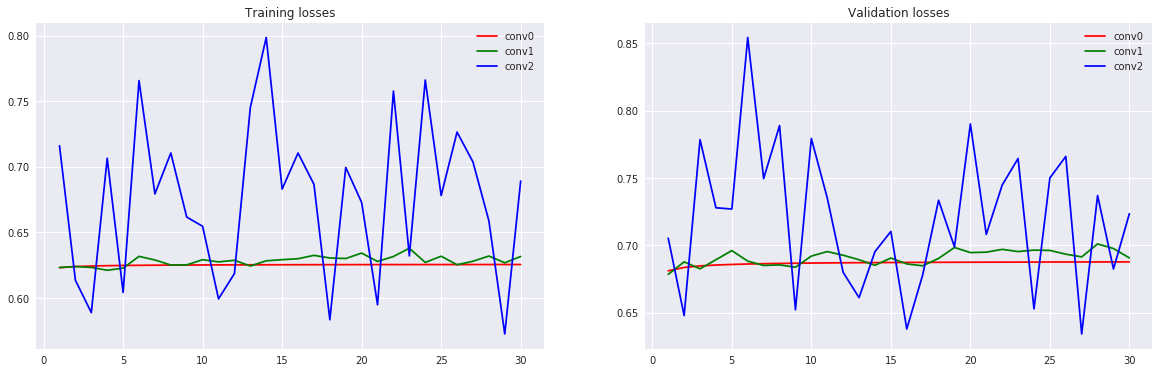

In [4]:
# Load training histories
with open("conv0_gdescent_0_000001_history.p", "rb") as f:
  conv0_history = pickle.load(f)
with open("conv1_gdescent_0_000001_history.p", "rb") as f:
  conv1_history = pickle.load(f)
with open("conv2_gdescent_0_000001_history.p", "rb") as f:
  conv2_history = pickle.load(f)

# Display train and validation losses
x = np.arange(1, 31)
plt.figure(figsize = (20, 6))
# Display train losses
plt.subplot(1, 2, 1)
plt.title("Training losses")
plt.plot(x, conv0_history["train_losses"], c="r", label="conv0")
plt.plot(x, conv1_history["train_losses"], c="g", label="conv1")
plt.plot(x, conv2_history["train_losses"], c="b", label="conv2")
plt.legend()
# Display validation losses
plt.subplot(1, 2, 2)
plt.title("Validation losses")
plt.plot(x, conv0_history["val_losses"], c="r", label="conv0")
plt.plot(x, conv1_history["val_losses"], c="g", label="conv1")
plt.plot(x, conv2_history["val_losses"], c="b", label="conv2")
plt.legend()

plt.show()

One can see that none of the models is able to converge

Check performance on the test set. Before computing metrics like accuracy, precision and recall, let's look at models predictions

In [5]:
# Load test set logits
conv0_logits = np.load("conv0_gdescent_0_000001_final_logits.npy")
conv1_logits = np.load("conv1_gdescent_0_000001_final_logits.npy")
conv2_logits = np.load("conv2_gdescent_0_000001_final_logits.npy")

# Print out number of positive predictions for all models
print("Conv0:", np.argmax(conv0_logits, 1).sum())
print("Conv1:", np.argmax(conv1_logits, 1).sum())
print("Conv2:", np.argmax(conv2_logits, 1).sum())

Conv0: 624
Conv1: 624
Conv2: 623


We can see that data inbalance is indeed a significant problem in this setting and computing performance metrics is pointless. Common ways of adressing inbalance is to augment or down-size the data, we will try to do that through adjusting the loss function.

### Try to adress the inbalanced dataset problem

Train first two models with different loss function

In [10]:
weights = {
    'wc1': tf.get_variable('W0', shape=(3,3,3,32), initializer=tf.contrib.layers.xavier_initializer()), 
    'wc2': tf.get_variable('W1', shape=(3,3,32,64), initializer=tf.contrib.layers.xavier_initializer()), 
    'wc3': tf.get_variable('W2', shape=(3,3,64,128), initializer=tf.contrib.layers.xavier_initializer()), 
    'wd1': tf.get_variable('W3', shape=(100352,1024), initializer=tf.contrib.layers.xavier_initializer()),
    'wd2': tf.get_variable("W4", shape=(1024,512), initializer=tf.contrib.layers.xavier_initializer()),
    'out': tf.get_variable('W6', shape=(512,2), initializer=tf.contrib.layers.xavier_initializer()), 
}
biases = {
    'bc1': tf.get_variable('B0', shape=(32), initializer=tf.contrib.layers.xavier_initializer()),
    'bc2': tf.get_variable('B1', shape=(64), initializer=tf.contrib.layers.xavier_initializer()),
    'bc3': tf.get_variable('B2', shape=(128), initializer=tf.contrib.layers.xavier_initializer()),
    'bd1': tf.get_variable('B3', shape=(1024), initializer=tf.contrib.layers.xavier_initializer()),
    'bd2': tf.get_variable("B4", shape=(512), initializer=tf.contrib.layers.xavier_initializer()),
    'out': tf.get_variable('B5', shape=(2), initializer=tf.contrib.layers.xavier_initializer()),
}


In [17]:
learning_rate = 0.001
batch_size = 16
test_batch_size = 16
n_epochs = 30
log = True
class_weight = 0.2   # Coefficient for adjusting loss function

# Define the graph
# Basic constants
n = train_images.shape[0]
steps = n // batch_size

# Define placeholders
x = tf.placeholder("float", [None, 224, 224, 3])
y = tf.placeholder("float", [None, 2])

# Define model predictions and corresponding cost
pred = conv_net0(x, weights, biases)
cost = tf.reduce_mean(tf.nn.weighted_cross_entropy_with_logits(targets=y, logits=pred, pos_weight=class_weight))

# Define optimizer
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

# Get array of correct predictions
correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))

# Get the accuracy
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Initialize the variables
init = tf.global_variables_initializer()

# Run the session
gpu_options = tf.GPUOptions(allow_growth=True)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
sess.run(init)

# Define performance lists
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Define temporary array for storing test test logits
n_test = test_images.shape[0]
test_logits = np.zeros((n_test, 2), dtype=np.float32)

# Iterate over epochs
for epoch in range(n_epochs):
    tep0 = time.time()
    # Iterate over batches
    for batch in range(steps):
        tb0 = time.time()
        # Get batch data
        batch_x = train_images[batch * batch_size:min((batch + 1) * batch_size, n)]
        batch_y = train_labels[batch * batch_size:min((batch + 1) * batch_size, n)]
        # Compute loss and batch accuracy
        _, loss, acc = sess.run([optimizer, cost, accuracy], feed_dict = {x: batch_x,
                                                                         y: batch_y})
        tb1 = time.time()
        # print("Epoch {0}, Batch {1}, time: {2}, loss: {3}, accuracy: {4}".format(
            # epoch, batch, tb1 - tb0, loss, acc))
    # Feed validation data into network and get the performance
    val_loss, val_acc = sess.run([cost,accuracy], feed_dict={x: validation_images,
                                                         y : validation_labels})
    # Update performance lists
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    train_losses.append(loss)
    train_accuracies.append(acc)

    tep1 = time.time()

    # Report after epoch
    if log:
        # print("********************************************")
        print("Epoch {0}, time: {1}, loss: {2}, accuracy: {3}".format(
                epoch, tep1 - tep0, val_loss, val_acc))
        # print("********************************************")
# After the training is complete, feed thethe test data into network and get logits
print()
print("Training finished")
test_steps = n_test // test_batch_size
for batch in range(test_steps):
  tb0 = time.time()
  # Get batch data
  test_batch_x = test_images[batch * test_batch_size:min((batch + 1) * test_batch_size, n_test)]
  # Compute batch logits
  logits = sess.run(pred, feed_dict={x: test_batch_x})
  # Update test logits storage variable
  test_logits[batch * test_batch_size:min((batch + 1) * batch_size, n_test)] = logits
  
# Close the session after all epochs
sess.close()
# Save training history
res_dict = {"val_losses": val_losses,
           "val_accs": val_accuracies,
           "train_losses": train_losses,
           "train_accs": train_accuracies}
with open("conv0_weighted_gdescent_0_000001_history.p", "wb") as f:
  pickle.dump(res_dict, f)
# Save logits
print()
print("Saving logits")
np.save("conv0_weighted_gdescent_0_000001_final_logits.npy", test_logits)
print("Finished")

Epoch 0, time: 152.22823333740234, loss: 0.2717391848564148, accuracy: 0.625
Epoch 1, time: 31.666032075881958, loss: 0.27218762040138245, accuracy: 0.625
Epoch 2, time: 30.419130325317383, loss: 0.27221423387527466, accuracy: 0.625
Epoch 3, time: 30.57606840133667, loss: 0.27218523621559143, accuracy: 0.625
Epoch 4, time: 30.514100790023804, loss: 0.27218905091285706, accuracy: 0.625
Epoch 5, time: 30.450452089309692, loss: 0.27218812704086304, accuracy: 0.625
Epoch 6, time: 30.372272729873657, loss: 0.27218785881996155, accuracy: 0.625
Epoch 7, time: 30.469025135040283, loss: 0.2721889019012451, accuracy: 0.625
Epoch 8, time: 30.45294690132141, loss: 0.27218878269195557, accuracy: 0.625
Epoch 9, time: 30.456026315689087, loss: 0.27218902111053467, accuracy: 0.625
Epoch 10, time: 30.499863862991333, loss: 0.27218902111053467, accuracy: 0.625
Epoch 11, time: 30.43889355659485, loss: 0.27218931913375854, accuracy: 0.625
Epoch 12, time: 30.41378927230835, loss: 0.27218931913375854, accur

In [18]:
# Load test set logits
conv0_logits = np.load("conv0_weighted_gdescent_0_000001_final_logits.npy")

# Print out number of positive predictions for all models
print("Conv0:", np.argmax(conv0_logits, 1).sum())


Conv0: 624


In [13]:
learning_rate = 0.001
batch_size = 16
test_batch_size = 16
n_epochs = 20
log = True
class_weight = 3.

# Define the graph
# Basic constants
n = train_images.shape[0]
steps = n // batch_size

# Define placeholders
x = tf.placeholder("float", [None, 224, 224, 3])
y = tf.placeholder("float", [None, 2])

# Define model predictions and corresponding cost
pred = conv_net1(x, weights, biases)
cost = tf.reduce_mean(tf.nn.weighted_cross_entropy_with_logits(targets=y, logits=pred, pos_weight=class_weight))

# Define optimizer
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

# Get array of correct predictions
correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))

# Get the accuracy
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Initialize the variables
init = tf.global_variables_initializer()

# Run the session
gpu_options = tf.GPUOptions(allow_growth=True)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
sess.run(init)

# Define performance lists
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Define temporary array for storing test test logits
n_test = test_images.shape[0]
test_logits = np.zeros((n_test, 2), dtype=np.float32)

# Iterate over epochs
for epoch in range(n_epochs):
    tep0 = time.time()
    # Iterate over batches
    for batch in range(steps):
        tb0 = time.time()
        # Get batch data
        batch_x = train_images[batch * batch_size:min((batch + 1) * batch_size, n)]
        batch_y = train_labels[batch * batch_size:min((batch + 1) * batch_size, n)]
        # Compute loss and batch accuracy
        _, loss, acc = sess.run([optimizer, cost, accuracy], feed_dict = {x: batch_x,
                                                                         y: batch_y})
        tb1 = time.time()
        # print("Epoch {0}, Batch {1}, time: {2}, loss: {3}, accuracy: {4}".format(
            # epoch, batch, tb1 - tb0, loss, acc))
    # Feed validation data into network and get the performance
    val_loss, val_acc = sess.run([cost,accuracy], feed_dict={x: validation_images,
                                                         y : validation_labels})
    # Update performance lists
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    train_losses.append(loss)
    train_accuracies.append(acc)

    tep1 = time.time()

    # Report after epoch
    if log:
        # print("********************************************")
        print("Epoch {0}, time: {1}, loss: {2}, accuracy: {3}".format(
                epoch, tep1 - tep0, val_loss, val_acc))
        # print("********************************************")
# After the training is complete, feed thethe test data into network and get logits
print()
print("Training finished")
test_steps = n_test // test_batch_size
for batch in range(test_steps):
  tb0 = time.time()
  # Get batch data
  test_batch_x = test_images[batch * test_batch_size:min((batch + 1) * test_batch_size, n_test)]
  # Compute batch logits
  logits = sess.run(pred, feed_dict={x: test_batch_x})
  # Update test logits storage variable
  test_logits[batch * test_batch_size:min((batch + 1) * batch_size, n_test)] = logits
  
# Close the session after all epochs
sess.close()
# Save training history
res_dict = {"val_losses": val_losses,
           "val_accs": val_accuracies,
           "train_losses": train_losses,
           "train_accs": train_accuracies}
with open("conv1_weighted_gdescent_0_000001_history.p", "wb") as f:
  pickle.dump(res_dict, f)
# Save logits
print()
print("Saving logits")
np.save("conv1_weighted_gdescent_0_000001_final_logits.npy", test_logits)
print("Finished")

Epoch 0, time: 158.95129656791687, loss: 1.1109304428100586, accuracy: 0.625
Epoch 1, time: 34.33546590805054, loss: 1.1199365854263306, accuracy: 0.625
Epoch 2, time: 32.93382453918457, loss: 1.1153401136398315, accuracy: 0.625
Epoch 3, time: 32.8713173866272, loss: 1.1141631603240967, accuracy: 0.625
Epoch 4, time: 32.866631269454956, loss: 1.1259243488311768, accuracy: 0.625
Epoch 5, time: 32.85822653770447, loss: 1.1306967735290527, accuracy: 0.625
Epoch 6, time: 32.75211763381958, loss: 1.1307649612426758, accuracy: 0.625
Epoch 7, time: 32.76058340072632, loss: 1.1171715259552002, accuracy: 0.625
Epoch 8, time: 32.74512529373169, loss: 1.1347070932388306, accuracy: 0.625
Epoch 9, time: 32.69084811210632, loss: 1.1286579370498657, accuracy: 0.625
Epoch 10, time: 32.82368230819702, loss: 1.140620470046997, accuracy: 0.625
Epoch 11, time: 33.045544385910034, loss: 1.1271238327026367, accuracy: 0.625
Epoch 12, time: 33.07614612579346, loss: 1.129084825515747, accuracy: 0.625
Epoch 13,

In [14]:
# Load test set logits
conv1_logits = np.load("conv1_weighted_gdescent_0_000001_final_logits.npy")

# Print out number of positive predictions for all models
print("Conv1:", np.argmax(conv1_logits, 1).sum())

Conv1: 624


I've also tried bunch of other adjustment coefficients and weighted loss functions not visible in the code, and nothing was working. It seems that learning convolutional network from scratch on relatively limited data is very hard when not using outer, pre-trained model learned on the large dataset which can efficiently detect low level features of the image.